# Import Libraries

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import roc_curve
from sklearn.metrics import average_precision_score
from sklearn.model_selection import cross_val_score

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV

# Import Data

In [3]:
df = pd.read_csv("data/sim_predm_panu.csv")

In [4]:
df.head()

,age,glu,hdl,ldl,bmi,dm
0,43,116,39,159,26,yes
1,37,110,52,174,32,yes
2,42,119,36,136,20,yes
3,48,119,37,176,27,yes
4,45,106,30,146,29,yes


Explore data and see that this is numerical data with binary outcome

#### Data Visualization

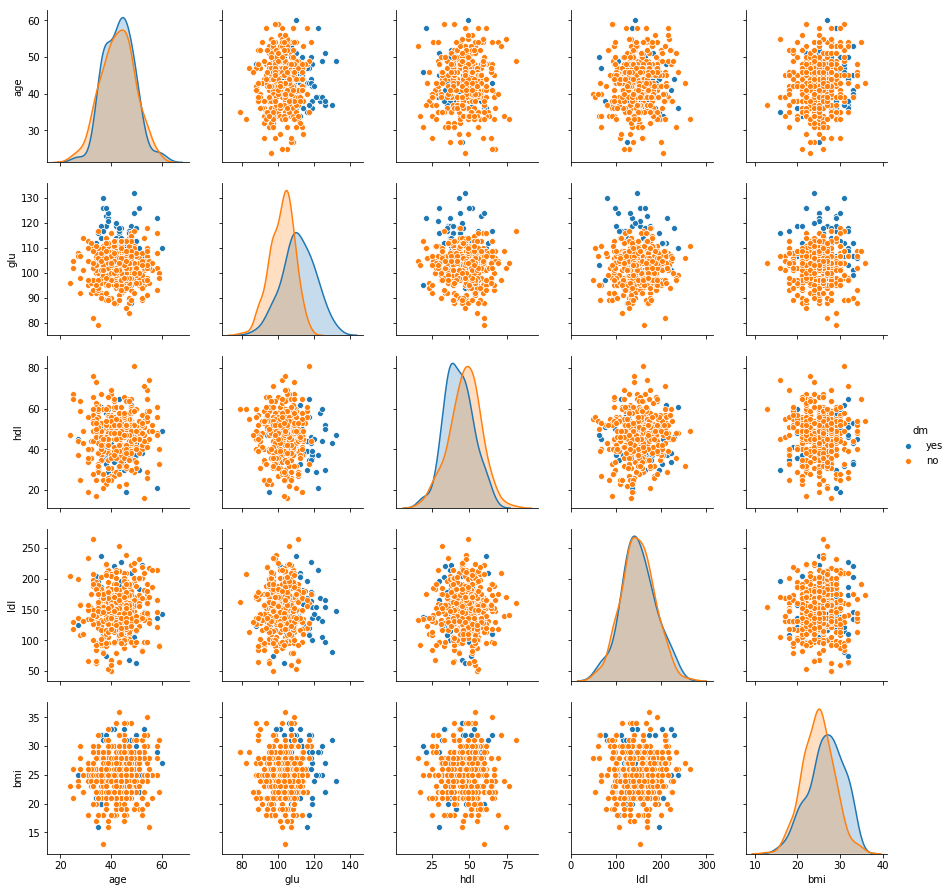

In [5]:
import seaborn as sns
sns.pairplot(df, hue="dm")

Data visualization helps to see properties of each features and how it can distinguish between DM and non-DM. Here, it shows that glu, hdl and bmi can be separated from DN and non-DM, while age and ldl are very hard to distinguish.

In [6]:
df.groupby('dm').count()

,age,glu,hdl,ldl,bmi
dm,,,,,
no,354,354,354,354,354
yes,71,71,71,71,71


# Define Function

We define functions because these functions will be called regularly. Therefore, create the code as function will help to reduce the time to code for each model significantly. Functions faciliate in reduction of number of variables as it return only interested variables into global environment and all the variables that are not called are kept in the local envrionment.

In [7]:
# Initialize to convert class from text to numerical. Then convert data from dataframe to array
def initialize (df):
    df.loc[df['dm']=='yes','dm']=1
    df.loc[df['dm']=='no','dm']=0
    y = df.iloc[:,-1]
    X = df.iloc[:,0:-1]
    X = X.values
    y = y.values
    return X,y

# Second initialize function for oversampling2 function
def initialize2 (df):
    y = df.iloc[:,-1]
    X = df.iloc[:,0:-1]
    X = X.values
    y = y.values
    return X,y

# Standardized train data using StandardScaler
def standardize (X):
    from sklearn.preprocessing import StandardScaler
    scaler = StandardScaler()
    X = scaler.fit_transform(X)
    return X

# Split data into train and test
def split (X, y):
    from sklearn.model_selection import train_test_split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=28)
    return X_train, X_test, y_train, y_test

# Undersampling
def under_sampling (X, y):
    from imblearn.under_sampling import ClusterCentroids
    cc = ClusterCentroids(random_state=28)
    X_underresampled, y_underresampled = cc.fit_resample(X, y)
    return X_underresampled, y_underresampled


# Oversampling data
def over_sampling (X, y):
    from imblearn.over_sampling import RandomOverSampler
    ros = RandomOverSampler(random_state=28)
    X_overresampled, y_overresampled = ros.fit_resample(X, y)
    return X_overresampled, y_overresampled

def over_sampling2 (X, y):
    from sklearn.utils import resample
    ovsampX = pd.DataFrame(data = X)
    ovsampy = pd.DataFrame(data = y)
    oversampconcate = pd.concat([ovsampX, ovsampy], axis = 1)
    df = resample(oversampconcate,random_state=28)   
    X, y = initialize2(df)
    X_final, y_final = over_sampling(X, y)
    return X_final, y_final

# Ploting ROC and PR curve for all models in different experiment
def full_ROC_PR (nb_dict, dt_dict, svm_dict):
    figROC, ax = plt.subplots(figsize=(6, 6))
    ax.plot(nb_dict["fpr"], nb_dict["tpr"], label="Naive Bayes, auc=" + str(nb_dict["ROC"]))
    ax.plot(dt_dict["fpr"], dt_dict["tpr"], label="Decision Tree, auc=" + str(dt_dict["ROC"]))
    ax.plot(svm_dict["fpr"], svm_dict["tpr"], label="SVM, auc=" + str(svm_dict["ROC"]))
    ax.plot(ax.get_ylim(), ax.get_xlim(), color="gray", linewidth=0.3)
    ax.set_xlabel("FPR")
    ax.set_ylabel("TPR")
    ax.set_xlim(left=0, right=1)
    ax.set_ylim(bottom=0, top=1)
    plt.legend(loc="lower right")
    
    figPR, ax = plt.subplots(figsize=(6, 6))
    ax.plot(nb_dict["precision","recall","thresholds"][1], 
            nb_dict["precision","recall","thresholds"][0], 
            label="Naive Bayes, average precision=" + str(nb_dict["AP"]))
    
    ax.plot(dt_dict["precision","recall","thresholds"][1], 
            dt_dict["precision","recall","thresholds"][0], 
            label="Decision Tree, average precision=" + str(dt_dict["AP"]))
    ax.plot(svm_dict["precision","recall","thresholds"][1], 
            svm_dict["precision","recall","thresholds"][0], 
            label="SVM, average precision=" + str(svm_dict["AP"]))
    ax.set_xlabel("Recall")
    ax.set_ylabel("Precision")
    ax.set_xlim(left=0, right=1)
    ax.set_ylim(bottom=0, top=1)
    plt.legend(loc="lower left")   
    plt.show()
    
    return figROC, figPR

# Plotting ROC and PR curve for each type of models for all experiments
def full_ROC_PR2 ():
    figROC_nb, ax = plt.subplots(figsize=(6, 6))
    ax.plot(a_nb_dict["fpr"], a_nb_dict["tpr"], label="Exp a, Naive Bayes, auc=" + str(a_nb_dict["ROC"]))
    ax.plot(b_nb_dict["fpr"], b_nb_dict["tpr"], label="Exp b, Naive Bayes, auc=" + str(b_nb_dict["ROC"]))
    ax.plot(c_nb_dict["fpr"], c_nb_dict["tpr"], label="Exp c, Naive Bayes, auc=" + str(c_nb_dict["ROC"]))
    ax.plot(d_nb_dict["fpr"], d_nb_dict["tpr"], label="Exp d, Naive Bayes, auc=" + str(d_nb_dict["ROC"]))
    ax.plot(e_nb_dict["fpr"], e_nb_dict["tpr"], label="Exp e, Naive Bayes, auc=" + str(e_nb_dict["ROC"]))
    ax.plot(f_nb_dict["fpr"], f_nb_dict["tpr"], label="Exp f, Naive Bayes, auc=" + str(f_nb_dict["ROC"]))
    ax.plot(g_nb_dict["fpr"], g_nb_dict["tpr"], label="Exp g, Naive Bayes, auc=" + str(g_nb_dict["ROC"]))
    ax.plot(a_nb_dict["fpr"], a_nb_dict["tpr"], label="Exp h, Naive Bayes, auc=" + str(a_nb_dict["ROC"]))
    ax.plot(ax.get_ylim(), ax.get_xlim(), color="gray", linewidth=0.3)
    ax.set_title('Naive Bayes ROC')
    ax.set_xlabel("FPR")
    ax.set_ylabel("TPR")
    ax.set_xlim(left=0, right=1)
    ax.set_ylim(bottom=0, top=1)
    plt.legend(loc="lower right")
    
    figROC_dt, ax = plt.subplots(figsize=(6, 6))
    ax.plot(a_dt_dict["fpr"], a_dt_dict["tpr"], label="Exp a, Decision Tree, auc=" + str(a_dt_dict["ROC"]))
    ax.plot(b_dt_dict["fpr"], b_dt_dict["tpr"], label="Exp b, Decision Tree, auc=" + str(b_dt_dict["ROC"]))
    ax.plot(c_dt_dict["fpr"], c_dt_dict["tpr"], label="Exp c, Decision Tree, auc=" + str(c_dt_dict["ROC"]))
    ax.plot(d_dt_dict["fpr"], d_dt_dict["tpr"], label="Exp d, Decision Tree, auc=" + str(d_dt_dict["ROC"]))
    ax.plot(e_dt_dict["fpr"], e_dt_dict["tpr"], label="Exp e, Decision Tree, auc=" + str(e_dt_dict["ROC"]))
    ax.plot(f_dt_dict["fpr"], f_dt_dict["tpr"], label="Exp f, Decision Tree, auc=" + str(f_dt_dict["ROC"]))
    ax.plot(g_dt_dict["fpr"], g_dt_dict["tpr"], label="Exp g, Decision Tree, auc=" + str(g_dt_dict["ROC"]))
    ax.plot(h_dt_dict["fpr"], h_dt_dict["tpr"], label="Exp h, Decision Tree, auc=" + str(h_dt_dict["ROC"]))
    ax.plot(ax.get_ylim(), ax.get_xlim(), color="gray", linewidth=0.3)
    ax.set_title('Decision Tree ROC')
    ax.set_xlabel("FPR")
    ax.set_ylabel("TPR")
    ax.set_xlim(left=0, right=1)
    ax.set_ylim(bottom=0, top=1)
    plt.legend(loc="lower right")
    
    figROC_svm, ax = plt.subplots(figsize=(6, 6))
    ax.plot(a_svm_dict["fpr"], a_svm_dict["tpr"], label="Exp a,SVM, auc=" + str(a_svm_dict["ROC"]))
    ax.plot(b_svm_dict["fpr"], b_svm_dict["tpr"], label="Exp b,SVM, auc=" + str(b_svm_dict["ROC"]))
    ax.plot(c_svm_dict["fpr"], c_svm_dict["tpr"], label="Exp c,SVM, auc=" + str(c_svm_dict["ROC"]))
    ax.plot(d_svm_dict["fpr"], d_svm_dict["tpr"], label="Exp d,SVM, auc=" + str(d_svm_dict["ROC"]))
    ax.plot(e_svm_dict["fpr"], e_svm_dict["tpr"], label="Exp e,SVM, auc=" + str(e_svm_dict["ROC"]))
    ax.plot(f_svm_dict["fpr"], f_svm_dict["tpr"], label="Exp f,SVM, auc=" + str(f_svm_dict["ROC"]))
    ax.plot(g_svm_dict["fpr"], g_svm_dict["tpr"], label="Exp g,SVM, auc=" + str(g_svm_dict["ROC"]))
    ax.plot(h_svm_dict["fpr"], h_svm_dict["tpr"], label="Exp h,SVM, auc=" + str(h_svm_dict["ROC"]))
    ax.plot(ax.get_ylim(), ax.get_xlim(), color="gray", linewidth=0.3)
    ax.set_title('SVM ROC')
    ax.set_xlabel("FPR")
    ax.set_ylabel("TPR")
    ax.set_xlim(left=0, right=1)
    ax.set_ylim(bottom=0, top=1)
    plt.legend(loc="lower right")
    
    figPR_nb, ax = plt.subplots(figsize=(6, 6))
    ax.plot(a_nb_dict["precision","recall","thresholds"][1], 
            a_nb_dict["precision","recall","thresholds"][0], 
            label="Exp a, Naive Bayes, average precision=" + str(a_nb_dict["AP"]))
    ax.plot(b_nb_dict["precision","recall","thresholds"][1], 
            b_nb_dict["precision","recall","thresholds"][0], 
            label="Exp b, Naive Bayes, average precision=" + str(b_nb_dict["AP"]))
    ax.plot(c_nb_dict["precision","recall","thresholds"][1], 
            c_nb_dict["precision","recall","thresholds"][0], 
            label="Exp c, Naive Bayes, average precision=" + str(c_nb_dict["AP"]))
    ax.plot(d_nb_dict["precision","recall","thresholds"][1], 
            d_nb_dict["precision","recall","thresholds"][0], 
            label="Exp d, Naive Bayes, average precision=" + str(d_nb_dict["AP"]))
    ax.plot(e_nb_dict["precision","recall","thresholds"][1], 
            e_nb_dict["precision","recall","thresholds"][0], 
            label="Exp e, Naive Bayes, average precision=" + str(e_nb_dict["AP"]))
    ax.plot(f_nb_dict["precision","recall","thresholds"][1], 
            f_nb_dict["precision","recall","thresholds"][0], 
            label="Exp f, Naive Bayes, average precision=" + str(f_nb_dict["AP"]))
    ax.plot(g_nb_dict["precision","recall","thresholds"][1], 
            g_nb_dict["precision","recall","thresholds"][0], 
            label="Exp g, Naive Bayes, average precision=" + str(g_nb_dict["AP"]))
    ax.plot(h_nb_dict["precision","recall","thresholds"][1], 
            h_nb_dict["precision","recall","thresholds"][0], 
            label="Exp h, Naive Bayes, average precision=" + str(h_nb_dict["AP"]))
    ax.set_title('Naive Bayes PR Curve')
    ax.set_xlabel("Recall")
    ax.set_ylabel("Precision")
    ax.set_xlim(left=0, right=1)
    ax.set_ylim(bottom=0, top=1)
    plt.legend(loc="lower left")      
    
    figPR_dt, ax = plt.subplots(figsize=(6, 6))
    ax.plot(a_dt_dict["precision","recall","thresholds"][1], 
            a_dt_dict["precision","recall","thresholds"][0], 
            label="Exp a, Decision Tree, average precision=" + str(a_dt_dict["AP"]))
    ax.plot(b_dt_dict["precision","recall","thresholds"][1], 
            b_dt_dict["precision","recall","thresholds"][0], 
            label="Exp b, Decision Tree, average precision=" + str(b_dt_dict["AP"]))
    ax.plot(c_dt_dict["precision","recall","thresholds"][1], 
            c_dt_dict["precision","recall","thresholds"][0], 
            label="Exp c, Decision Tree, average precision=" + str(c_dt_dict["AP"]))
    ax.plot(d_dt_dict["precision","recall","thresholds"][1], 
            d_dt_dict["precision","recall","thresholds"][0], 
            label="Exp d, Decision Tree, average precision=" + str(d_dt_dict["AP"]))
    ax.plot(e_dt_dict["precision","recall","thresholds"][1], 
            e_dt_dict["precision","recall","thresholds"][0], 
            label="Exp e, Decision Tree, average precision=" + str(e_dt_dict["AP"]))
    ax.plot(f_dt_dict["precision","recall","thresholds"][1], 
            f_dt_dict["precision","recall","thresholds"][0], 
            label="Exp f, Decision Tree, average precision=" + str(f_dt_dict["AP"]))
    ax.plot(g_dt_dict["precision","recall","thresholds"][1], 
            g_dt_dict["precision","recall","thresholds"][0], 
            label="Exp g, Decision Tree, average precision=" + str(g_dt_dict["AP"]))
    ax.plot(h_dt_dict["precision","recall","thresholds"][1], 
            h_dt_dict["precision","recall","thresholds"][0], 
            label="Exp h, Decision Tree, average precision=" + str(h_dt_dict["AP"]))
    ax.set_title('Decision Tree PR Curve')
    ax.set_xlabel("Recall")
    ax.set_ylabel("Precision")
    ax.set_xlim(left=0, right=1)
    ax.set_ylim(bottom=0, top=1)
    plt.legend(loc="lower left")  
    
    figPR_svm, ax = plt.subplots(figsize=(6, 6))
    ax.plot(a_svm_dict["precision","recall","thresholds"][1], 
            a_svm_dict["precision","recall","thresholds"][0], 
            label="Exp a, SVM, average precision=" + str(a_svm_dict["AP"]))
    ax.plot(b_svm_dict["precision","recall","thresholds"][1], 
            b_svm_dict["precision","recall","thresholds"][0], 
            label="Exp b, SVM, average precision=" + str(b_svm_dict["AP"]))
    ax.plot(c_svm_dict["precision","recall","thresholds"][1], 
            c_svm_dict["precision","recall","thresholds"][0], 
            label="Exp c, SVM, average precision=" + str(c_svm_dict["AP"]))
    ax.plot(d_svm_dict["precision","recall","thresholds"][1], 
            d_svm_dict["precision","recall","thresholds"][0], 
            label="Exp d, SVM, average precision=" + str(d_svm_dict["AP"]))
    ax.plot(e_svm_dict["precision","recall","thresholds"][1], 
            e_svm_dict["precision","recall","thresholds"][0], 
            label="Exp e, SVM, average precision=" + str(e_svm_dict["AP"]))
    ax.plot(f_svm_dict["precision","recall","thresholds"][1], 
            f_svm_dict["precision","recall","thresholds"][0], 
            label="Exp f, SVM, average precision=" + str(f_svm_dict["AP"]))
    ax.plot(g_svm_dict["precision","recall","thresholds"][1], 
            g_svm_dict["precision","recall","thresholds"][0], 
            label="Exp g, SVM, average precision=" + str(g_svm_dict["AP"]))
    ax.plot(h_svm_dict["precision","recall","thresholds"][1], 
            h_svm_dict["precision","recall","thresholds"][0], 
            label="Exp h, SVM, average precision=" + str(h_svm_dict["AP"]))
    ax.set_title('SVM PR Curve')
    ax.set_xlabel("Recall")
    ax.set_ylabel("Precision")
    ax.set_xlim(left=0, right=1)
    ax.set_ylim(bottom=0, top=1)
    plt.legend(loc="lower left")  
    
    return figROC_nb, figROC_dt, figROC_svm, figPR_nb, figPR_dt, figPR_svm

# Define Model Function

Models code are put in as functions because the model will be called total of 24 times. This will save time by not have to do duplicate coding. Also, it helps in reduction of number of variables. If this doesn't code as function, we need to have unique variables for all of the three models for each experiments.

All the results obtain from the model calculation are kept as dictionary. This is because it helps in organizing the results of the model in each experiment, which make it easy to call the result to do other analysis as well (eg. figure creation, confusion matrix and etc.).

## Naive Bayes

Gaussian Naive Bayes is used as the features are continuous variables. However, Gridsearch is not used in this model as there is no hyperparameter to tune.

In [8]:
def nbay (X_train, X_test, y_train, y_test):
    from sklearn.naive_bayes import GaussianNB

    gnb = GaussianNB()
    gnb_scores = cross_val_score(gnb, X_train, y_train, cv=10)
    gnb_scores.mean()
    
    #Random Search
    param_dist = {"var_smoothing": (1e-07 ,1e-08, 1e-09, 1e-10, 1e-11, 1e-12)}
     
    rs_gnb = RandomizedSearchCV(estimator = gnb, 
                               param_distributions = param_dist, 
                               n_iter = 10, 
                               random_state=28,
                               scoring='accuracy', 
                               cv=10,
                               n_jobs=-1)
    rs_gnb.fit(X_train, y_train)
    rs_gnb.best_params_
    rs_gnb.best_score_
    
    

    
    #Grid SearchrCV
    gs_gnb = GridSearchCV(gnb, param_grid={
        "var_smoothing": (1e-04 ,1e-05, 1e-06 ,1e-07 ,1e-08, 1e-09, 1e-10, 1e-11, 1e-12)}, cv=10, scoring='accuracy',
        n_jobs = -1)
    gs_gnb.fit(X_train, y_train)
    gs_gnb.best_params_
    gs_gnb.best_score_
    
    #Test    
    yhat_nb = gs_gnb.best_estimator_.predict(X_test) 
        
    #Evaluation
    nb = {}
    
    nb["acc"] = round(accuracy_score(y_test, yhat_nb), 2)
    nb["con_mat"] = confusion_matrix(y_test, yhat_nb, labels=[1,0])
    nb["precision", "recall", "thresholds"] = precision_recall_curve(y_test, yhat_nb, pos_label=1)
    nb["ROC"] = round(roc_auc_score(y_test, yhat_nb), 2)
    nb["AP"] = round(average_precision_score(y_test, gs_gnb.predict_proba(X_test)[:,1]), 2)
    
        #Cross validation from train
    nb["CV"] = round(gnb_scores.mean(), 2)
    
    #Ploting confusion matrix
    cm = confusion_matrix(y_test, yhat_nb, labels=[1, 0])
    plt.clf()
    figcm_nb = plt.figure()
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Wistia)
    plt.colorbar()
    classNames = ['Positive','Negative']
    plt.title('Confusion Matrix')
    plt.ylabel('Predicted label')
    plt.xlabel('True label')
    tick_marks = np.arange(len(classNames))
    plt.xticks(tick_marks, classNames, rotation=45)
    plt.yticks(tick_marks, classNames)
    s = [['TP','FP'], ['FN', 'TN']]   
    for i in range(2):
        for j in range(2):
            plt.text(j,i, str(s[i][j])+" = "+str(cm[i][j]))
    
#    plt.savefig('E:/MEGA 2 - Personal/Personal - Gmail/PhD/RADS602 Data Mining and Machine Learning/Assignment II Data/NB1_CONMAT.png')
    plt.show()
    
    #Plotting ROC
    fpr, tpr, thresholds = roc_curve(y_test, yhat_nb, pos_label=1)
    
    nb["fpr"] = fpr
    nb["tpr"] = tpr
    nb["thresholds"] = thresholds
    
    figROC_nb, ax = plt.subplots(figsize=(6, 6))
    ax.plot(fpr, tpr, color="tomato", label="Naive Bayes, auc=" + str(nb["ROC"]))
    ax.plot(ax.get_ylim(), ax.get_xlim(), color="gray", linewidth=0.3)
    ax.set_xlabel("FPR")
    ax.set_ylabel("TPR")
    ax.set_xlim(left=0, right=1)
    ax.set_ylim(bottom=0, top=1)
    plt.legend(loc="lower right")
#    plt.savefig('E:/MEGA 2 - Personal/Personal - Gmail/PhD/RADS602 Data Mining and Machine Learning/Assignment II Data/NB1_ROC.png')
    plt.show()  
    
    #Plotting PR Curve
    figPR_nb, ax = plt.subplots(figsize=(6, 6))
    ax.plot(nb["precision","recall","thresholds"][1], nb["precision","recall","thresholds"][0], color="green", label="Naive Bayes, average precision=" + str(nb["AP"]))
    ax.set_xlabel("Recall")
    ax.set_ylabel("Precision")
    ax.set_xlim(left=0, right=1)
    ax.set_ylim(bottom=0, top=1)
    plt.legend(loc="lower left")
#    plt.savefig('E:/MEGA 2 - Personal/Personal - Gmail/PhD/RADS602 Data Mining and Machine Learning/Assignment II Data/NB1_PR.png')
    plt.show()
    
    return nb, figcm_nb, figROC_nb, figPR_nb
    
#    return nb["acc"], nb["con_mat"], nb["precision", "recall", "thresholds"], nb["ROC"], nb["AP"], gnb_scores, nb

## Decision Tree

In [9]:
def dt (X_train, X_test, y_train, y_test):
    from sklearn.tree import DecisionTreeClassifier
    dt = DecisionTreeClassifier(random_state=28)
    
    
    #Random Search
    #Random search from 1 to 10 and different criterion
    param_dist = {"criterion": ("gini", "entropy"),
                  "max_depth": np.arange(2, 10),
                  "min_samples_split": np.arange(2,10,1)}
    
    rs_dt = RandomizedSearchCV(estimator = dt, 
                               param_distributions = param_dist, 
                               n_iter = 10, 
                               random_state=28,
                               scoring='accuracy', 
                               cv=10,
                               n_jobs=-1)
    
    rs_dt = rs_dt.fit(X_train, y_train)
    rs_dt.best_params_
    rs_dt.best_score_
    
    #Grid SearchrchCV
    #Use best parameters from grid search and find range between 20% lower and 20% higer of max debt 
    gs_dt = GridSearchCV(dt, param_grid={
        "criterion": ("gini", "entropy"),
        "max_depth": np.arange(2,rs_dt.best_params_["max_depth"]*10,1),
        "min_samples_split": np.arange(rs_dt.best_params_["min_samples_split"],rs_dt.best_params_["min_samples_split"]*10,1)}, cv=10,
        n_jobs = -1)
    gs_dt.fit(X_train, y_train)
    gs_dt.best_params_
    gs_dt.best_score_
    
    dt_scores = cross_val_score(gs_dt.best_estimator_, X_train, y_train, cv=10)
    dt_scores.mean()
    
    #Tuned
    dt_scores = cross_val_score(gs_dt.best_estimator_, X_train, y_train, cv=10)
    dt_scores.mean()
    
    #Test
    #Use the best estimators from grid search to predict X_test
    yhat_dt = gs_dt.best_estimator_.predict(X_test)
    
    #Evaluation
    dt = {}
    
    dt["acc"] = round(accuracy_score(y_test, yhat_dt), 2)
    dt["con_mat"] = confusion_matrix(y_test, yhat_dt, labels=[1,0])
    dt["precision", "recall", "thresholds"] = precision_recall_curve(y_test, yhat_dt, pos_label=1)
    dt["ROC"] = round(roc_auc_score(y_test, yhat_dt), 2)
    dt["AP"] = round(average_precision_score(y_test, gs_dt.best_estimator_.predict_proba(X_test)[:,1]), 2)
    
        #Cross validation from train
    dt["CV"] = round(dt_scores.mean(), 2)
    
    
    #Ploting confusion matrix
    cm = confusion_matrix(y_test, yhat_dt, labels=[1, 0])
    plt.clf()
    figcm_dt = plt.figure()
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Wistia)
    plt.colorbar()
    classNames = ['Positive','Negative']
    plt.title('Confusion Matrix')
    plt.ylabel('Predicted label')
    plt.xlabel('True label')
    tick_marks = np.arange(len(classNames))
    plt.xticks(tick_marks, classNames, rotation=45)
    plt.yticks(tick_marks, classNames)
    s = [['TP','FP'], ['FN', 'TN']]   
    for i in range(2):
        for j in range(2):
            plt.text(j,i, str(s[i][j])+" = "+str(cm[i][j]))
       
    plt.savefig('E:/MEGA 2 - Personal/Personal - Gmail/PhD/RADS602 Data Mining and Machine Learning/Assignment II Data/DT1_CONMAT.png')
    plt.show()
    
    #Plotting ROC
    fpr, tpr, thresholds = roc_curve(y_test, yhat_dt, pos_label=1)
    
    dt["fpr"] = fpr
    dt["tpr"] = tpr
    dt["thresholds"] = thresholds
    
    figROC_dt, ax = plt.subplots(figsize=(6, 6))
    ax.plot(fpr, tpr, color="tomato", label="Decision Tree, auc=" + str(dt["ROC"]))
    ax.plot(ax.get_ylim(), ax.get_xlim(), color="gray", linewidth=0.3)
    ax.set_xlabel("FPR")
    ax.set_ylabel("TPR")
    ax.set_xlim(left=0, right=1)
    ax.set_ylim(bottom=0, top=1)
    plt.legend(loc="lower right")
    plt.savefig('E:/MEGA 2 - Personal/Personal - Gmail/PhD/RADS602 Data Mining and Machine Learning/Assignment II Data/DT1_ROC.png')   
    plt.show()
    
    #Plotting PR Curve
    figPR_dt, ax = plt.subplots(figsize=(6, 6))
    ax.plot(dt["precision","recall","thresholds"][1], dt["precision","recall","thresholds"][0], color="green", label="Decision Tree, average precision=" + str(dt["AP"]))
    ax.set_xlabel("Recall")
    ax.set_ylabel("Precision")
    ax.set_xlim(left=0, right=1)
    ax.set_ylim(bottom=0, top=1)
    plt.legend(loc="lower left")
    plt.savefig('E:/MEGA 2 - Personal/Personal - Gmail/PhD/RADS602 Data Mining and Machine Learning/Assignment II Data/DT1_PR.png')
    plt.show()

    return dt, figcm_dt, figROC_dt, figPR_dt

## SVM

In [10]:
def svm (X_train, X_test, y_train, y_test):
    from sklearn import svm
    svc=svm.SVC(verbose=1, probability=True, random_state=28)
    
    #Random search using C range from 1-20, different kernel and gamma.
    params = {'C': np.arange(1,20), 
              'kernel': ['linear','rbf'],
              'gamma': np.logspace(-9, 3, 13)}
    
    rs_svm = RandomizedSearchCV(estimator = svc, 
                               param_distributions = params, 
                               n_iter = 10, 
                               random_state=28,
                               scoring='accuracy', 
                               cv=10,               
                               n_jobs=-1)
    
    rs_svm.fit(X_train,y_train)
    rs_svm.best_params_
    rs_svm.best_score_
    
    #Grid search using best C value from random search. C range from 20% less to 20% higher of the best C value
    #Gamma value from random search is used. This can be improved be grid search of gamma value. 
    #But due to very long-time procession, the best gamma value from random search is used.
    
    gs_svm = GridSearchCV(svc, param_grid={
        'C': np.arange(rs_svm.best_params_["C"]*0.8, rs_svm.best_params_["C"]*1.2,1),
        'kernel': [rs_svm.best_params_["kernel"]],
        'gamma': [rs_svm.best_params_["gamma"]]},
        n_jobs=-1)    
    gs_svm.fit(X_train, y_train)
    gs_svm.best_params_
    gs_svm.best_score_
    
    svm_scores = cross_val_score(gs_svm.best_estimator_, X_train, y_train, cv=10)
    svm_scores.mean()
    
    #Test
    yhat_svm = gs_svm.best_estimator_.predict(X_test)
      
    #Evaluation
    svm = {}
    svm["acc"] = round(accuracy_score(y_test, yhat_svm), 2)
    svm["con_mat"] = confusion_matrix(y_test, yhat_svm, labels=[1,0])
    svm["precision", "recall", "thresholds"] = precision_recall_curve(y_test, yhat_svm, pos_label=1)
    svm["ROC"] = round(roc_auc_score(y_test, yhat_svm), 2)
    svm["AP"] = round(average_precision_score(y_test, gs_svm.best_estimator_.predict_proba(X_test)[:,1]), 2)
        #Cross validation from train
    svm["CV"] = round(svm_scores.mean(), 2)
    
    #Plot Confusion Matrix
    cm = confusion_matrix(y_test, yhat_svm, labels=[1, 0])
    plt.clf()
    figcm_svm = plt.figure()
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Wistia)
    plt.colorbar()
    classNames = ['Positive','Negative']
    plt.title('Confusion Matrix')
    plt.ylabel('Predicted label')
    plt.xlabel('True label')
    tick_marks = np.arange(len(classNames))
    plt.xticks(tick_marks, classNames, rotation=45)
    plt.yticks(tick_marks, classNames)
    s = [['TP','FP'], ['FN', 'TN']]   
    for i in range(2):
        for j in range(2):
            plt.text(j,i, str(s[i][j])+" = "+str(cm[i][j]))
    
#    plt.savefig('E:/MEGA 2 - Personal/Personal - Gmail/PhD/RADS602 Data Mining and Machine Learning/Assignment II Data/SVM1_CONMAT.png')
    plt.show()
    
    #Plotting ROC
    fpr, tpr, thresholds = roc_curve(y_test, yhat_svm, pos_label=1)
    
    svm["fpr"] = fpr
    svm["tpr"] = tpr
    svm["thresholds"] = thresholds
    
    figROC_svm, ax = plt.subplots(figsize=(6, 6))
    ax.plot(fpr, tpr, color="tomato", label="SVM, auc=" + str(svm["ROC"]))
    ax.plot(ax.get_ylim(), ax.get_xlim(), color="gray", linewidth=0.3)
    ax.set_xlabel("FPR")
    ax.set_ylabel("TPR")
    ax.set_xlim(left=0, right=1)
    ax.set_ylim(bottom=0, top=1)
    plt.legend(loc="lower right")
    
#    plt.savefig('E:/MEGA 2 - Personal/Personal - Gmail/PhD/RADS602 Data Mining and Machine Learning/Assignment II Data/SVM1_ROC.png') 
    plt.show()
    
    #Plotting PR Curve
    figPR_svm, ax = plt.subplots(figsize=(6, 6))
    ax.plot(svm["precision","recall","thresholds"][1], svm["precision","recall","thresholds"][0], color="green", label="SVM, average precision=" + str(svm["AP"]))
    ax.set_xlabel("Recall")
    ax.set_ylabel("Precision")
    ax.set_xlim(left=0, right=1)
    ax.set_ylim(bottom=0, top=1)
    plt.legend(loc="lower left")
    
#    plt.savefig('E:/MEGA 2 - Personal/Personal - Gmail/PhD/RADS602 Data Mining and Machine Learning/Assignment II Data/SVM1_PR.png')
    plt.show()
    
    return svm, figcm_svm, figROC_svm, figPR_svm


# Run Model

After we define functions, now it is very easy to construct and evaluate the model by exexcute the functions and return the dictionary (contain all the results) into global environment. The results in the dictionary are called to construct figures and evaluate the model by execute the created-function again.

### a) Run models using the defined functions above with the follow steps.
1. Initialize
2. Standardize
3. Split data
4. Run models

## Naive Bayes

E:\Users\User\Anaconda3\envs\CEB\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
E:\Users\User\Anaconda3\envs\CEB\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
E:\Users\User\Anaconda3\envs\CEB\lib\site-packages\sklearn\model_selection\_search.py:271: UserWarning: The total space of parameters 6 is smaller than n_iter=10. Running 6 iterations. For exhaustive searches, use GridSearchCV.
  % (grid_size, self.n_iter, grid_size), UserWarning)
E:\Users\User\Anaconda3\envs\CEB\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set siz

<Figure size 432x288 with 0 Axes>

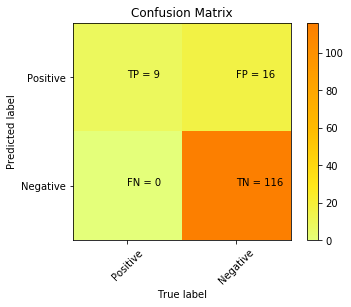

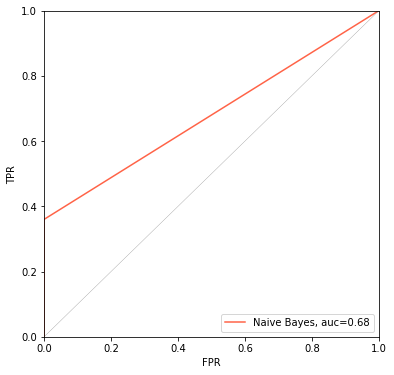

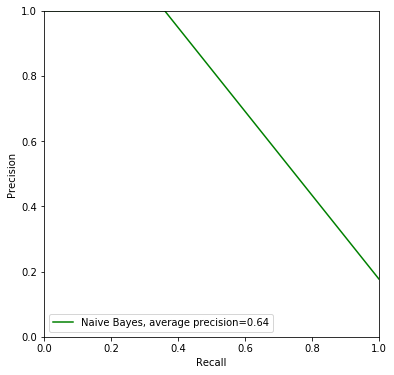

In [11]:
X, y = initialize(df)
X = standardize(X)
X_train, X_test, y_train, y_test = split(X, y)
a_nb_dict, a_figcm_nb, a_figROC_nb, a_figPR_nb = nbay(X_train, X_test, y_train, y_test)


The above figures shows the confusion matrix, ROC curve, PR curve and accuracy.

In [12]:
a_nb_dict

{'acc': 0.89, 'con_mat': array([[  9,  16],
        [  0, 116]], dtype=int64), ('precision',
  'recall',
  'thresholds'): (array([0.17730496, 1.        , 1.        ]), array([1.  , 0.36, 0.  ]), array([0, 1], dtype=int64)), 'ROC': 0.68, 'AP': 0.64, 'CV': 0.87, 'fpr': array([0., 0., 1.]), 'tpr': array([0.  , 0.36, 1.  ]), 'thresholds': array([2, 1, 0], dtype=int64)}

### Decision Tree

E:\Users\User\Anaconda3\envs\CEB\lib\site-packages\pandas\core\ops.py:1649: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  result = method(y)
E:\Users\User\Anaconda3\envs\CEB\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
E:\Users\User\Anaconda3\envs\CEB\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
E:\Users\User\Anaconda3\envs\CEB\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
E:\Users\User\Anacond

<Figure size 432x288 with 0 Axes>

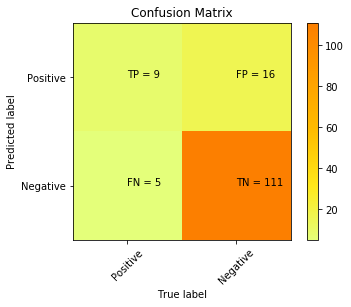

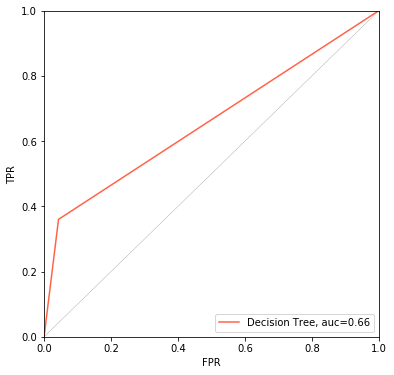

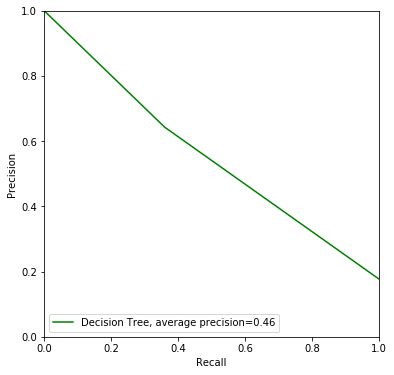

In [13]:
X, y = initialize(df)
X = standardize(X)
X_train, X_test, y_train, y_test = split(X, y)
a_dt_dict, a_figcm_dt, a_figROC_dt, a_figPR_dt = dt(X_train, X_test, y_train, y_test)


In [14]:
print("Cross validaiton before tuning is: ",a_dt_dict["CV"])
print("Cross validaiton after tuning is: ", a_dt_dict["acc"])

Cross validaiton before tuning is:  0.86
Cross validaiton after tuning is:  0.85


In [15]:
a_dt_dict

{'acc': 0.85, 'con_mat': array([[  9,  16],
        [  5, 111]], dtype=int64), ('precision',
  'recall',
  'thresholds'): (array([0.17730496, 0.64285714, 1.        ]), array([1.  , 0.36, 0.  ]), array([0, 1], dtype=int64)), 'ROC': 0.66, 'AP': 0.46, 'CV': 0.86, 'fpr': array([0.        , 0.04310345, 1.        ]), 'tpr': array([0.  , 0.36, 1.  ]), 'thresholds': array([2, 1, 0], dtype=int64)}

### SVM

E:\Users\User\Anaconda3\envs\CEB\lib\site-packages\pandas\core\ops.py:1649: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  result = method(y)
E:\Users\User\Anaconda3\envs\CEB\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
E:\Users\User\Anaconda3\envs\CEB\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
E:\Users\User\Anaconda3\envs\CEB\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
E:\Users\User\Anacond

[LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM]

<Figure size 432x288 with 0 Axes>

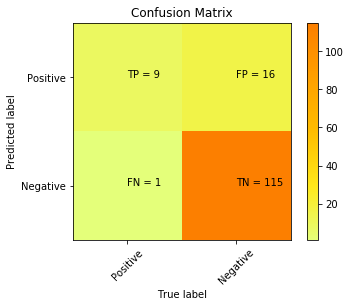

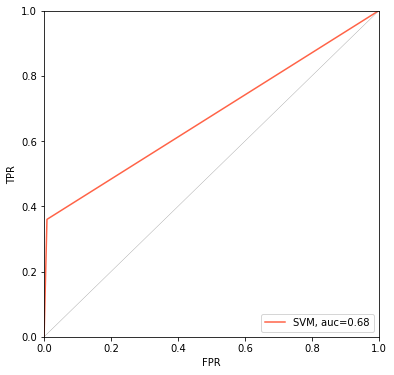

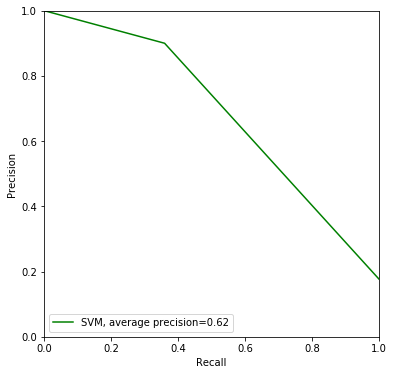

In [16]:
X, y = initialize(df)
X = standardize(X)
X_train, X_test, y_train, y_test = split(X, y)
a_svm_dict, a_figcm_svm, a_figROC_svm, a_figPR_svm = svm(X_train, X_test, y_train, y_test)


In [17]:
print("Cross validaiton before tuning is: ",a_svm_dict["CV"])
print("Cross validaiton after tuning is: ", a_svm_dict["acc"])


Cross validaiton before tuning is:  0.88
Cross validaiton after tuning is:  0.88


### b) Run models using the defined functions above with the follow steps.
1. Initialize
2. Split data
3. Run models

### Naive Bayes

E:\Users\User\Anaconda3\envs\CEB\lib\site-packages\pandas\core\ops.py:1649: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  result = method(y)
E:\Users\User\Anaconda3\envs\CEB\lib\site-packages\sklearn\model_selection\_search.py:271: UserWarning: The total space of parameters 6 is smaller than n_iter=10. Running 6 iterations. For exhaustive searches, use GridSearchCV.
  % (grid_size, self.n_iter, grid_size), UserWarning)
E:\Users\User\Anaconda3\envs\CEB\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
E:\Users\User\Anaconda3\envs\CEB\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in versi

<Figure size 432x288 with 0 Axes>

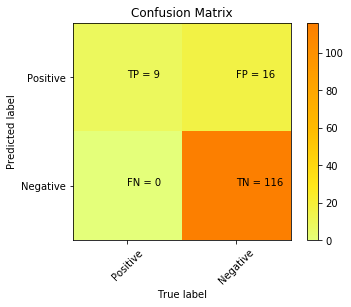

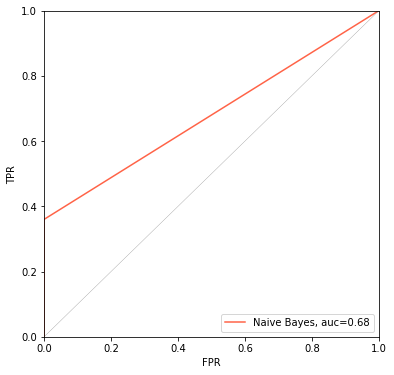

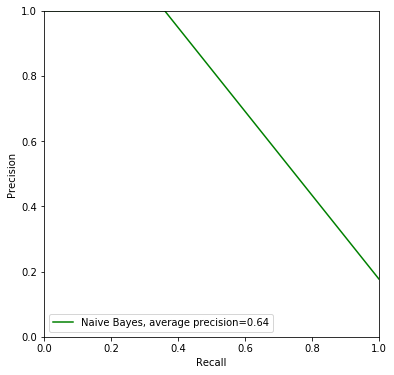

In [18]:
X, y = initialize(df)
X_train, X_test, y_train, y_test = split(X, y)
b_nb_dict, b_figcm_nb, b_figROC_nb, b_figPR_nb = nbay(X_train, X_test, y_train, y_test)


In [19]:
b_nb_dict["acc"]

0.89

### Decision Tree

E:\Users\User\Anaconda3\envs\CEB\lib\site-packages\pandas\core\ops.py:1649: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  result = method(y)
E:\Users\User\Anaconda3\envs\CEB\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
E:\Users\User\Anaconda3\envs\CEB\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


<Figure size 432x288 with 0 Axes>

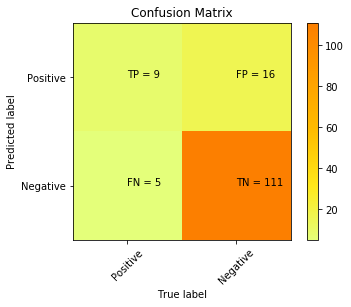

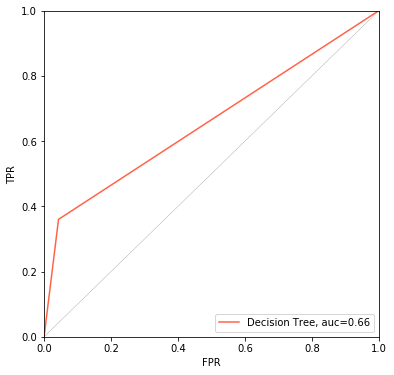

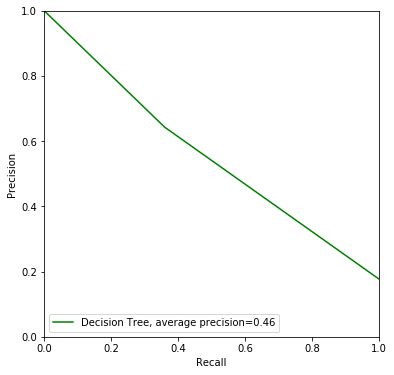

In [20]:
X, y = initialize(df)
X_train, X_test, y_train, y_test = split(X, y)
b_dt_dict, b_figcm_dt, b_figROC_dt, b_figPR_dt = dt(X_train, X_test, y_train, y_test)


In [21]:
print("Cross validaiton before tuning is: ",b_dt_dict["CV"])
print("Cross validaiton after tuning is: ", b_dt_dict["acc"])

Cross validaiton before tuning is:  0.86
Cross validaiton after tuning is:  0.85


### SVM

E:\Users\User\Anaconda3\envs\CEB\lib\site-packages\pandas\core\ops.py:1649: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  result = method(y)
E:\Users\User\Anaconda3\envs\CEB\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


[LibSVM]

E:\Users\User\Anaconda3\envs\CEB\lib\site-packages\sklearn\model_selection\_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)


[LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM]

<Figure size 432x288 with 0 Axes>

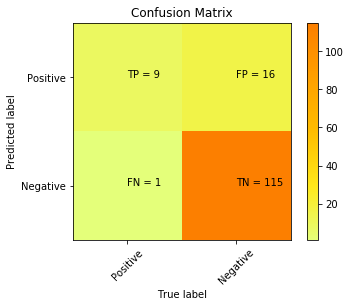

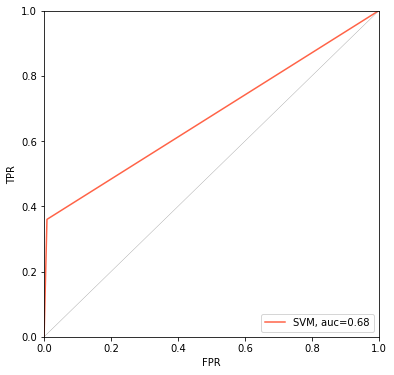

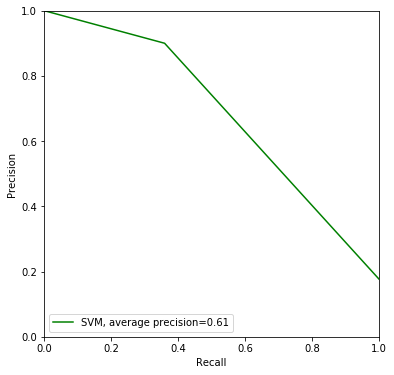

In [22]:
X, y = initialize(df)
X_train, X_test, y_train, y_test = split(X, y)
b_svm_dict, b_figcm_svm, b_figROC_svm, b_figPR_svm = svm(X_train, X_test, y_train, y_test)


In [23]:
print("Cross validaiton before tuning is: ",b_svm_dict["CV"])
print("Cross validaiton after tuning is: ", b_svm_dict["acc"])

Cross validaiton before tuning is:  0.88
Cross validaiton after tuning is:  0.88


### C) Run models using the defined functions above with the follow steps.
1. Initialize
2. Under Sampling
3. Split data
4. Run models

### Naive Bayes

E:\Users\User\Anaconda3\envs\CEB\lib\site-packages\pandas\core\ops.py:1649: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  result = method(y)
E:\Users\User\Anaconda3\envs\CEB\lib\site-packages\sklearn\model_selection\_search.py:271: UserWarning: The total space of parameters 6 is smaller than n_iter=10. Running 6 iterations. For exhaustive searches, use GridSearchCV.
  % (grid_size, self.n_iter, grid_size), UserWarning)
E:\Users\User\Anaconda3\envs\CEB\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
E:\Users\User\Anaconda3\envs\CEB\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in versi

<Figure size 432x288 with 0 Axes>

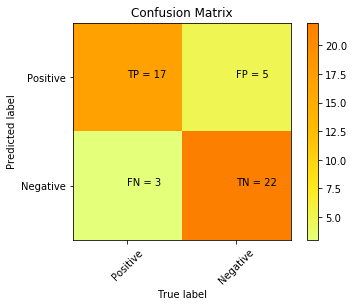

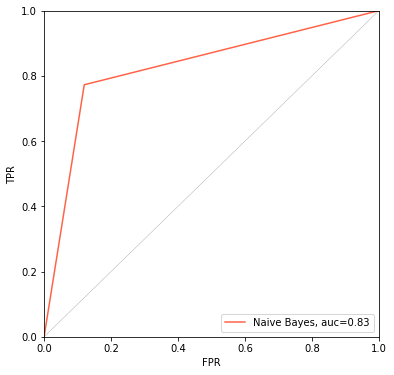

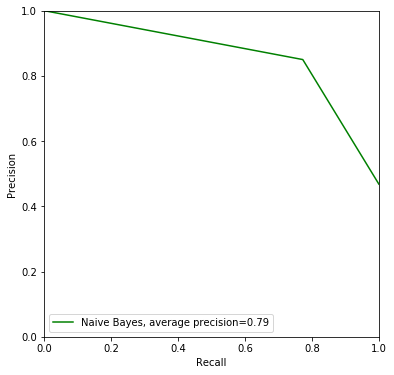

In [24]:
X, y = initialize(df)
X, y = under_sampling(X, y)
X_train, X_test, y_train, y_test = split(X, y)
c_nb_dict, c_cm_nb, c_figROC_nb, c_figPR_nb = nbay(X_train, X_test, y_train, y_test)


In [25]:
c_nb_dict["acc"]

0.83

### Decision Tree

E:\Users\User\Anaconda3\envs\CEB\lib\site-packages\pandas\core\ops.py:1649: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  result = method(y)
E:\Users\User\Anaconda3\envs\CEB\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
E:\Users\User\Anaconda3\envs\CEB\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


<Figure size 432x288 with 0 Axes>

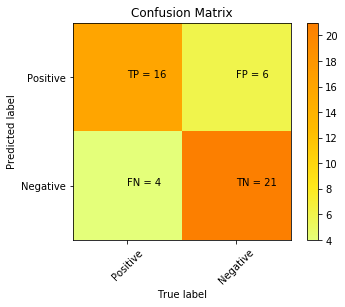

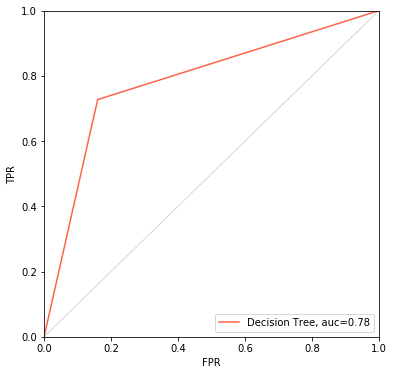

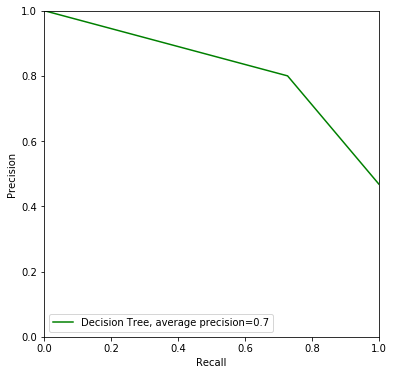

In [26]:
X, y = initialize(df)
X, y = under_sampling(X, y)
X_train, X_test, y_train, y_test = split(X, y)
c_dt_dict, c_cm_dt, c_figROC_dt, c_figPR_dt = dt(X_train, X_test, y_train, y_test)


In [27]:
print("Cross validaiton before tuning is: ",c_dt_dict["CV"])
print("Cross validaiton after tuning is: ", c_dt_dict["acc"])

Cross validaiton before tuning is:  0.77
Cross validaiton after tuning is:  0.79


### SVM

E:\Users\User\Anaconda3\envs\CEB\lib\site-packages\pandas\core\ops.py:1649: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  result = method(y)
E:\Users\User\Anaconda3\envs\CEB\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


[LibSVM]

E:\Users\User\Anaconda3\envs\CEB\lib\site-packages\sklearn\model_selection\_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
E:\Users\User\Anaconda3\envs\CEB\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


[LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM]

<Figure size 432x288 with 0 Axes>

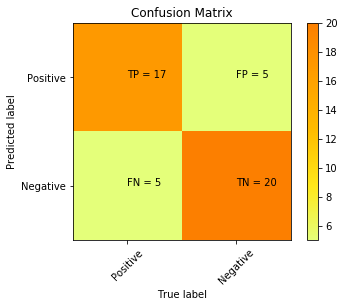

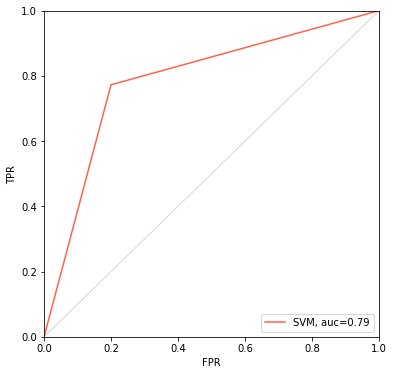

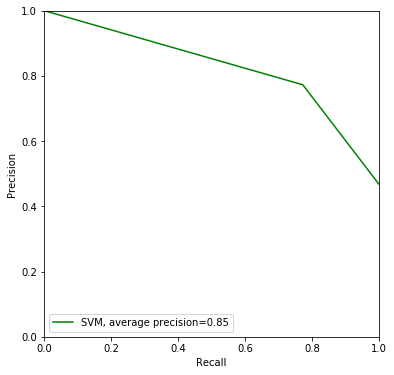

In [28]:
X, y = initialize(df)
X, y = under_sampling(X, y)
X_train, X_test, y_train, y_test = split(X, y)
c_svm_dict, c_cm_svm, c_figROC_svm, c_figPR_svm = svm(X_train, X_test, y_train, y_test)


In [29]:
print("Cross validaiton before tuning is: ",c_svm_dict["CV"])
print("Cross validaiton after tuning is: ", c_svm_dict["acc"])


Cross validaiton before tuning is:  0.75
Cross validaiton after tuning is:  0.79


### D) Run models using the defined functions above with the follow steps.
1. Initialize
2. Over Sampling
3. Split data
4. Run models

### Naive Bayes

E:\Users\User\Anaconda3\envs\CEB\lib\site-packages\pandas\core\ops.py:1649: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  result = method(y)
E:\Users\User\Anaconda3\envs\CEB\lib\site-packages\sklearn\model_selection\_search.py:271: UserWarning: The total space of parameters 6 is smaller than n_iter=10. Running 6 iterations. For exhaustive searches, use GridSearchCV.
  % (grid_size, self.n_iter, grid_size), UserWarning)
E:\Users\User\Anaconda3\envs\CEB\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
E:\Users\User\Anaconda3\envs\CEB\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in versi

<Figure size 432x288 with 0 Axes>

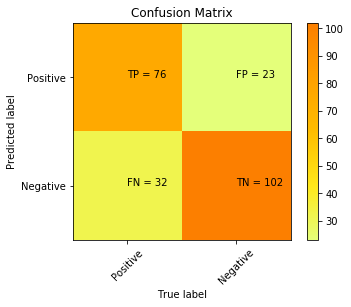

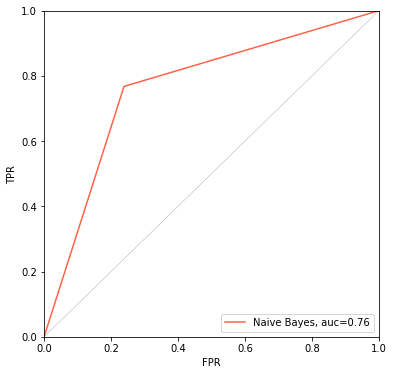

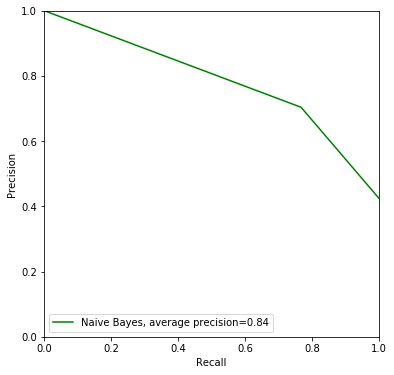

In [30]:
X, y = initialize(df)
X, y = over_sampling2(X, y)
X_train, X_test, y_train, y_test = split(X, y)
d_nb_dict, d_cm_nb, d_figROC_nb, d_figPR_nb = nbay(X_train, X_test, y_train, y_test)


In [31]:
d_nb_dict["acc"]

0.76

### Decision Tree

E:\Users\User\Anaconda3\envs\CEB\lib\site-packages\pandas\core\ops.py:1649: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  result = method(y)
E:\Users\User\Anaconda3\envs\CEB\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
E:\Users\User\Anaconda3\envs\CEB\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


<Figure size 432x288 with 0 Axes>

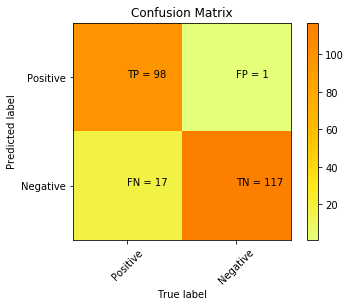

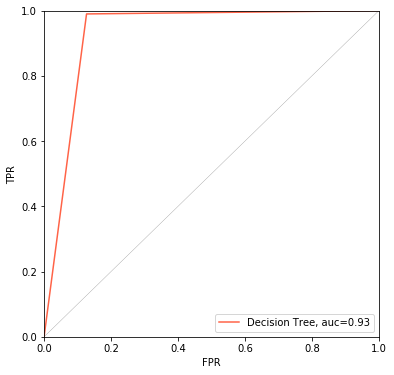

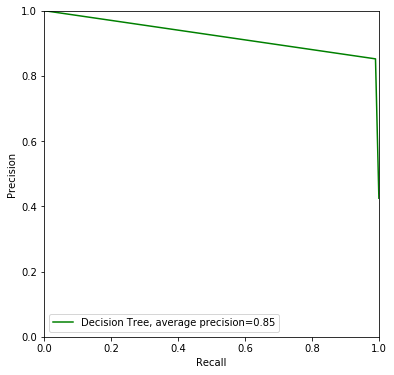

In [32]:
X, y = initialize(df)
X, y = over_sampling2(X, y)
X_train, X_test, y_train, y_test = split(X, y)
d_dt_dict, d_cm_dt, d_figROC_dt, d_figPR_dt = dt(X_train, X_test, y_train, y_test)


In [33]:
print("Cross validaiton before tuning is: ",d_dt_dict["CV"])
print("Cross validaiton after tuning is: ", d_dt_dict["acc"])


Cross validaiton before tuning is:  0.95
Cross validaiton after tuning is:  0.92


### SVM

E:\Users\User\Anaconda3\envs\CEB\lib\site-packages\pandas\core\ops.py:1649: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  result = method(y)


[LibSVM][LibSVM]

E:\Users\User\Anaconda3\envs\CEB\lib\site-packages\sklearn\model_selection\_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)


[LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM]

<Figure size 432x288 with 0 Axes>

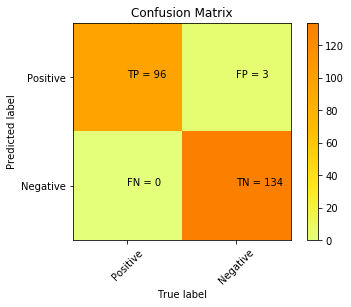

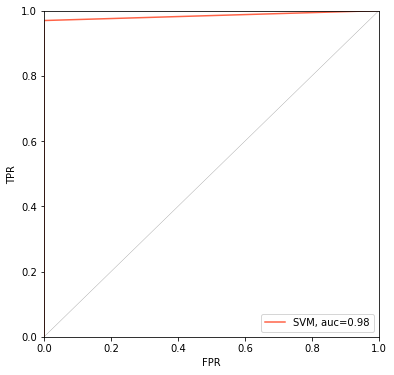

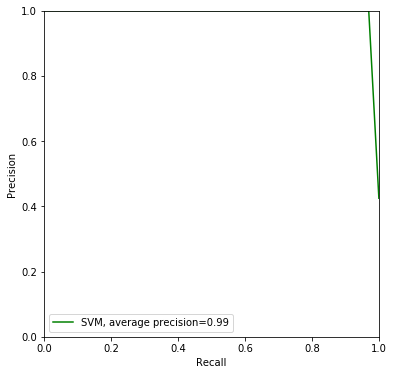

In [34]:
X, y = initialize(df)
X, y = over_sampling2(X, y)
X_train, X_test, y_train, y_test = split(X, y)
d_svm_dict, d_cm_svm, d_figROC_svm, d_figPR_svm = svm(X_train, X_test, y_train, y_test)


In [35]:
print("Cross validaiton before tuning is: ",d_svm_dict["CV"])
print("Cross validaiton after tuning is: ", d_svm_dict["acc"])


Cross validaiton before tuning is:  1.0
Cross validaiton after tuning is:  0.99


### E) Run models using the defined functions above with the follow steps.
1. Initialize
2. Under Sampling
3. Over Sampling
4. Split data
5. Run models

### Naive Bayes

E:\Users\User\Anaconda3\envs\CEB\lib\site-packages\pandas\core\ops.py:1649: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  result = method(y)
E:\Users\User\Anaconda3\envs\CEB\lib\site-packages\sklearn\model_selection\_search.py:271: UserWarning: The total space of parameters 6 is smaller than n_iter=10. Running 6 iterations. For exhaustive searches, use GridSearchCV.
  % (grid_size, self.n_iter, grid_size), UserWarning)
E:\Users\User\Anaconda3\envs\CEB\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
E:\Users\User\Anaconda3\envs\CEB\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in versi

<Figure size 432x288 with 0 Axes>

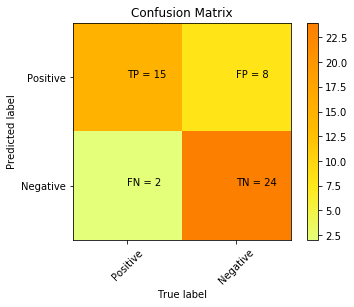

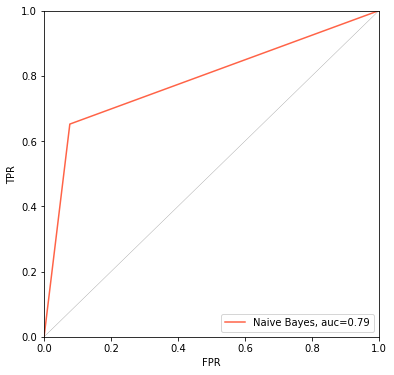

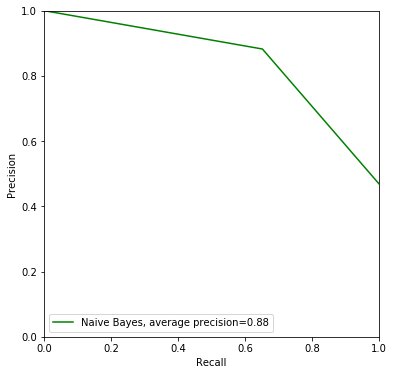

In [36]:
X, y = initialize(df)
X, y = under_sampling(X, y)
X, y = over_sampling2(X, y)
X_train, X_test, y_train, y_test = split(X, y)
e_nb_dict, e_cm_nb, e_figROC_nb, e_figPR_nb = nbay(X_train, X_test, y_train, y_test)


In [37]:
e_nb_dict["acc"]

0.8

### Decision Tree

E:\Users\User\Anaconda3\envs\CEB\lib\site-packages\pandas\core\ops.py:1649: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  result = method(y)
E:\Users\User\Anaconda3\envs\CEB\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
E:\Users\User\Anaconda3\envs\CEB\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


<Figure size 432x288 with 0 Axes>

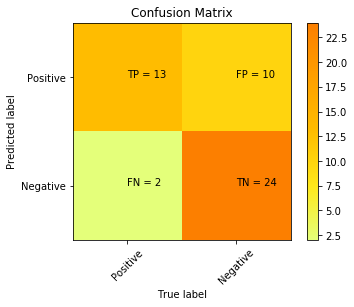

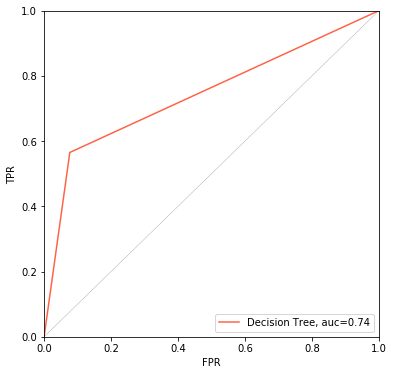

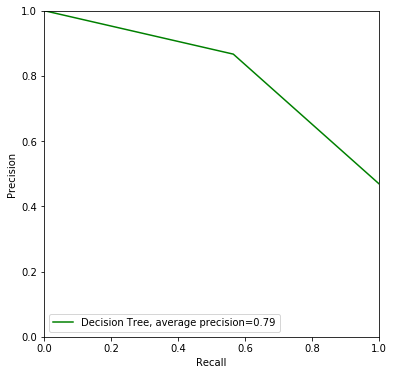

In [38]:
X, y = initialize(df)
X, y = under_sampling(X, y)
X, y = over_sampling2(X, y)
X_train, X_test, y_train, y_test = split(X, y)
e_dt_dict, e_cm_dt, e_figROC_dt, e_figPR_dt = dt(X_train, X_test, y_train, y_test)


In [39]:
print("Cross validaiton before tuning is: ",e_dt_dict["CV"])
print("Cross validaiton after tuning is: ", e_dt_dict["acc"])

Cross validaiton before tuning is:  0.87
Cross validaiton after tuning is:  0.76


### SVM

E:\Users\User\Anaconda3\envs\CEB\lib\site-packages\pandas\core\ops.py:1649: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  result = method(y)


[LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM]

E:\Users\User\Anaconda3\envs\CEB\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
E:\Users\User\Anaconda3\envs\CEB\lib\site-packages\sklearn\model_selection\_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
E:\Users\User\Anaconda3\envs\CEB\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


<Figure size 432x288 with 0 Axes>

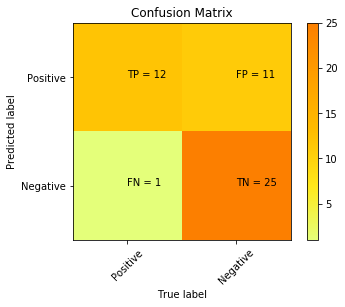

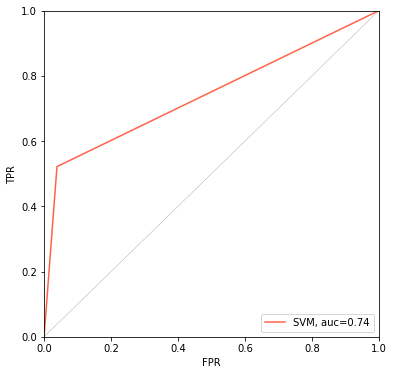

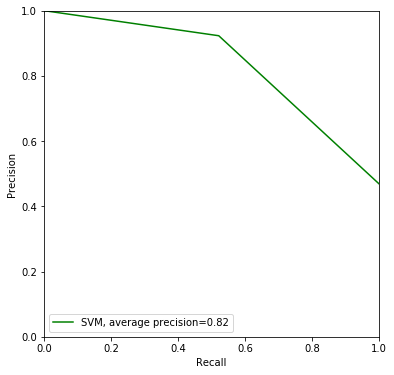

In [40]:
X, y = initialize(df)
X, y = under_sampling(X, y)
X, y = over_sampling2(X, y)
X_train, X_test, y_train, y_test = split(X, y)
e_svm_dict, e_cm_svm, e_figROC_svm, e_figPR_svm = svm(X_train, X_test, y_train, y_test)


In [41]:
print("Cross validaiton before tuning is: ",e_svm_dict["CV"])
print("Cross validaiton after tuning is: ", e_svm_dict["acc"])

Cross validaiton before tuning is:  0.81
Cross validaiton after tuning is:  0.76


### F) Run models using the defined functions above with the follow steps.
1. Initialize
2. Under Sampling
3. Standardize
4. Split data
5. Run models

### Naive Bayes

E:\Users\User\Anaconda3\envs\CEB\lib\site-packages\pandas\core\ops.py:1649: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  result = method(y)
E:\Users\User\Anaconda3\envs\CEB\lib\site-packages\sklearn\model_selection\_search.py:271: UserWarning: The total space of parameters 6 is smaller than n_iter=10. Running 6 iterations. For exhaustive searches, use GridSearchCV.
  % (grid_size, self.n_iter, grid_size), UserWarning)
E:\Users\User\Anaconda3\envs\CEB\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
E:\Users\User\Anaconda3\envs\CEB\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in versi

<Figure size 432x288 with 0 Axes>

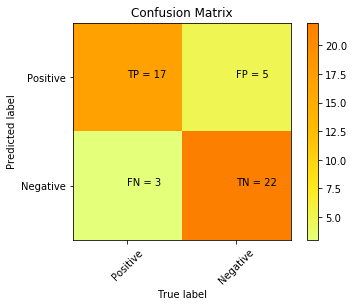

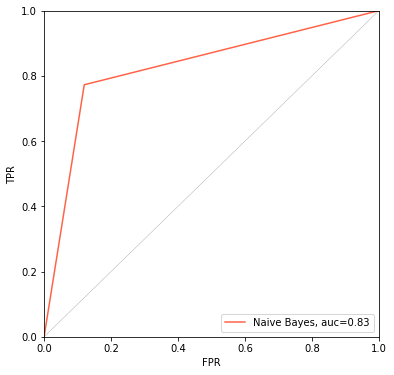

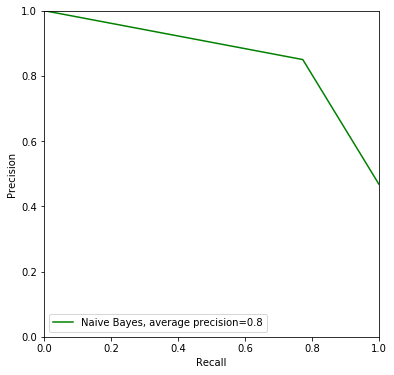

In [42]:
X, y = initialize(df)
X, y = under_sampling(X, y)
X = standardize(X)
X_train, X_test, y_train, y_test = split(X, y)
f_nb_dict, f_cm_nb, f_figROC_nb, f_figPR_nb = nbay(X_train, X_test, y_train, y_test)


In [43]:
f_nb_dict["acc"]

0.83

### Decision Tree

E:\Users\User\Anaconda3\envs\CEB\lib\site-packages\pandas\core\ops.py:1649: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  result = method(y)
E:\Users\User\Anaconda3\envs\CEB\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
E:\Users\User\Anaconda3\envs\CEB\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


<Figure size 432x288 with 0 Axes>

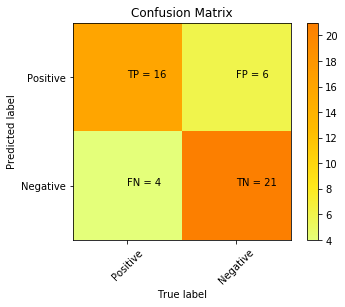

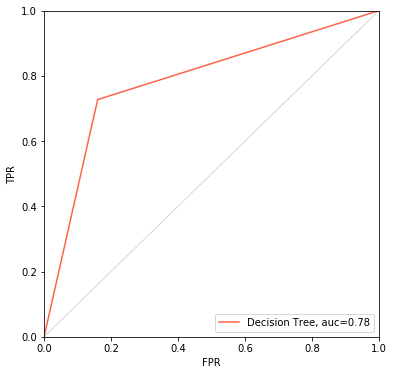

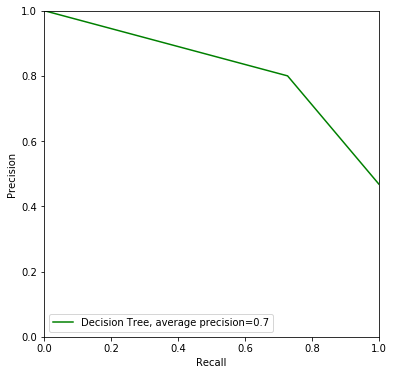

In [44]:
X, y = initialize(df)
X, y = under_sampling(X, y)
X = standardize(X)
X_train, X_test, y_train, y_test = split(X, y)
f_dt_dict, f_cm_dt, f_figROC_dt, f_figPR_dt = dt(X_train, X_test, y_train, y_test)


In [45]:
print("Cross validaiton before tuning is: ",f_dt_dict["CV"])
print("Cross validaiton after tuning is: ", f_dt_dict["acc"])

Cross validaiton before tuning is:  0.77
Cross validaiton after tuning is:  0.79


### SVM

E:\Users\User\Anaconda3\envs\CEB\lib\site-packages\pandas\core\ops.py:1649: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  result = method(y)
E:\Users\User\Anaconda3\envs\CEB\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
E:\Users\User\Anaconda3\envs\CEB\lib\site-packages\sklearn\model_selection\_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
E:\Users\User\Anaconda3\envs\CEB\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in ve

[LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM]

<Figure size 432x288 with 0 Axes>

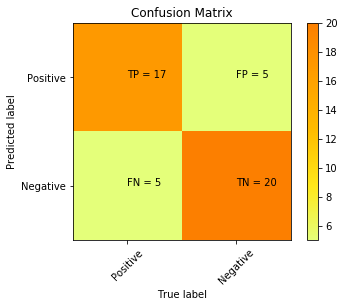

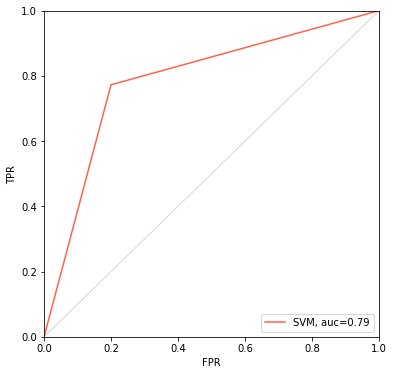

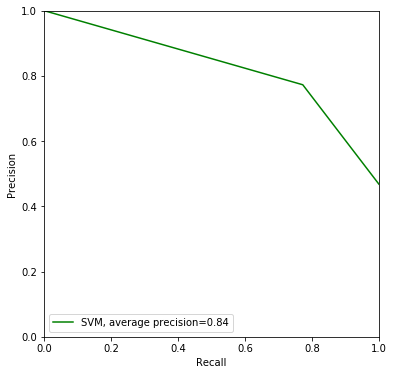

In [46]:
X, y = initialize(df)
X, y = under_sampling(X, y)
X = standardize(X)
X_train, X_test, y_train, y_test = split(X, y)
f_svm_dict, f_cm_svm, f_figROC_svm, f_figPR_svm = svm(X_train, X_test, y_train, y_test)


In [47]:
print("Cross validaiton before tuning is: ",f_svm_dict["CV"])
print("Cross validaiton after tuning is: ", f_svm_dict["acc"])

Cross validaiton before tuning is:  0.76
Cross validaiton after tuning is:  0.79


### G) Run models using the defined functions above with the follow steps.
1. Initialize
2. Over Sampling
3. Standardize
4. Split data
5. Run models

### Naive Bayes

E:\Users\User\Anaconda3\envs\CEB\lib\site-packages\pandas\core\ops.py:1649: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  result = method(y)
E:\Users\User\Anaconda3\envs\CEB\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
E:\Users\User\Anaconda3\envs\CEB\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
E:\Users\User\Anaconda3\envs\CEB\lib\site-packages\sklearn\model_selection\_search.py:271: UserWarning: The total space of parameters 6 is smaller than n_iter=10. Running 6 iterations. For exhaustive searches, use GridSearchCV.
  % (grid_size, self.n_iter, grid_size), UserWarning)
E:\Users\User\Anaconda3\envs\CEB\lib\site-package

<Figure size 432x288 with 0 Axes>

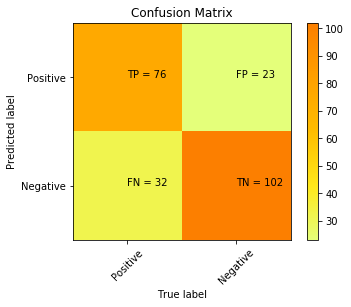

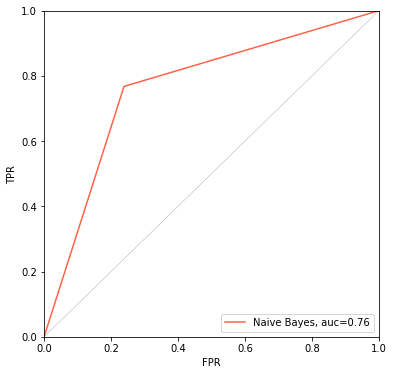

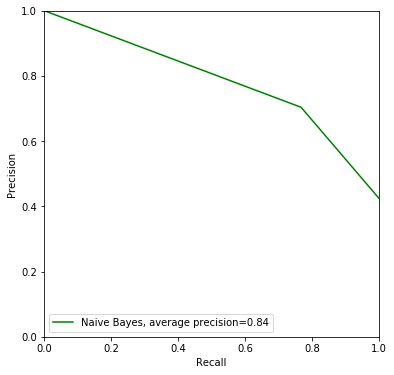

In [48]:
X, y = initialize(df)
X, y = over_sampling2(X, y)
X = standardize(X)
X_train, X_test, y_train, y_test = split(X, y)
g_nb_dict, g_cm_nb, g_figROC_nb, g_figPR_nb = nbay(X_train, X_test, y_train, y_test)


In [49]:
g_nb_dict["acc"]

0.76

### Decision Tree

E:\Users\User\Anaconda3\envs\CEB\lib\site-packages\pandas\core\ops.py:1649: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  result = method(y)
E:\Users\User\Anaconda3\envs\CEB\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
E:\Users\User\Anaconda3\envs\CEB\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
E:\Users\User\Anaconda3\envs\CEB\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
E:\Users\User\Anacond

<Figure size 432x288 with 0 Axes>

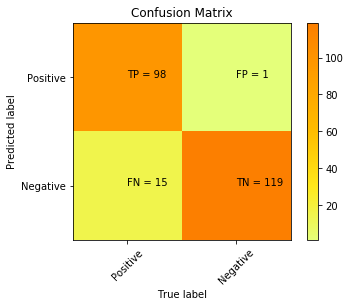

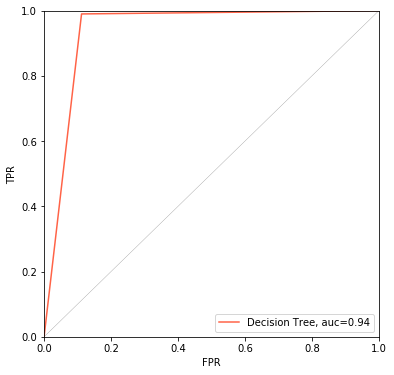

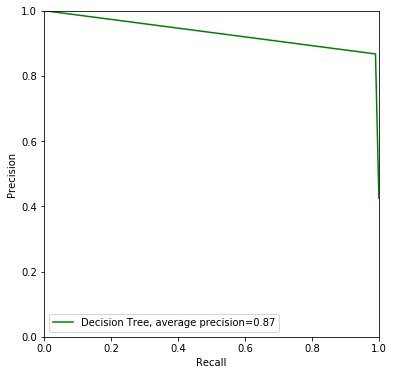

In [50]:
X, y = initialize(df)
X, y = over_sampling2(X, y)
X = standardize(X)
X_train, X_test, y_train, y_test = split(X, y)
g_dt_dict, g_cm_dt, g_figROC_dt, g_figPR_dt = dt(X_train, X_test, y_train, y_test)


In [51]:
print("Cross validaiton before tuning is: ",g_dt_dict["CV"])
print("Cross validaiton after tuning is: ", g_dt_dict["acc"])

Cross validaiton before tuning is:  0.95
Cross validaiton after tuning is:  0.93


### SVM

E:\Users\User\Anaconda3\envs\CEB\lib\site-packages\pandas\core\ops.py:1649: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  result = method(y)
E:\Users\User\Anaconda3\envs\CEB\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
E:\Users\User\Anaconda3\envs\CEB\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


[LibSVM][LibSVM][LibSVM][LibSVM]

E:\Users\User\Anaconda3\envs\CEB\lib\site-packages\sklearn\model_selection\_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)


[LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM]

<Figure size 432x288 with 0 Axes>

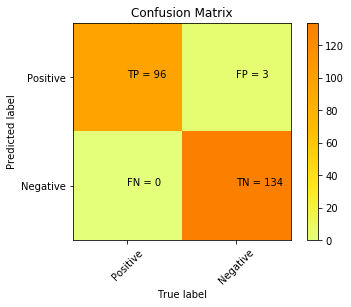

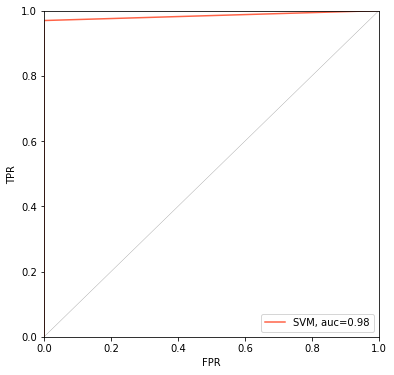

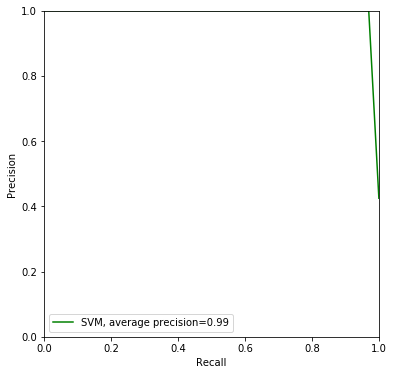

In [52]:
X, y = initialize(df)
X, y = over_sampling2(X, y)
X = standardize(X)
X_train, X_test, y_train, y_test = split(X, y)
g_svm_dict, g_cm_svm, g_figROC_svm, g_figPR_svm= svm(X_train, X_test, y_train, y_test)


In [53]:
print("Cross validaiton before tuning is: ",g_svm_dict["CV"])
print("Cross validaiton after tuning is: ", g_svm_dict["acc"])

Cross validaiton before tuning is:  1.0
Cross validaiton after tuning is:  0.99


### H) Run models using the defined functions above with the follow steps.
1. Initialize
2. Under Sampling
3. Over Sampling
4. Split data
5. Run models

### Naive Bayes

E:\Users\User\Anaconda3\envs\CEB\lib\site-packages\pandas\core\ops.py:1649: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  result = method(y)
E:\Users\User\Anaconda3\envs\CEB\lib\site-packages\sklearn\model_selection\_search.py:271: UserWarning: The total space of parameters 6 is smaller than n_iter=10. Running 6 iterations. For exhaustive searches, use GridSearchCV.
  % (grid_size, self.n_iter, grid_size), UserWarning)
E:\Users\User\Anaconda3\envs\CEB\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
E:\Users\User\Anaconda3\envs\CEB\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in versi

<Figure size 432x288 with 0 Axes>

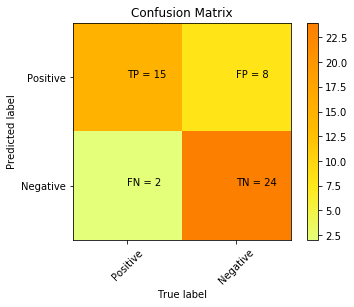

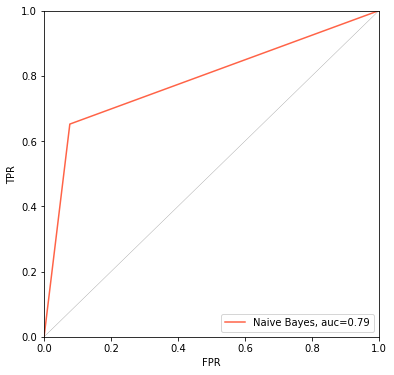

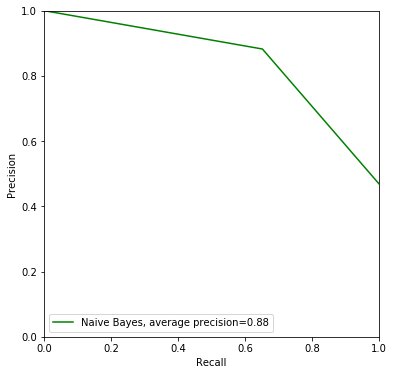

In [54]:
X, y = initialize(df)
X, y = under_sampling(X, y)
X, y = over_sampling2(X, y)
X = standardize(X)
X_train, X_test, y_train, y_test = split(X, y)
h_nb_dict, h_cm_nb, h_figROC_nb, h_figPR_nb = nbay(X_train, X_test, y_train, y_test)


In [55]:
h_nb_dict["acc"]

0.8

### Decision Tree

E:\Users\User\Anaconda3\envs\CEB\lib\site-packages\pandas\core\ops.py:1649: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  result = method(y)
E:\Users\User\Anaconda3\envs\CEB\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
E:\Users\User\Anaconda3\envs\CEB\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


<Figure size 432x288 with 0 Axes>

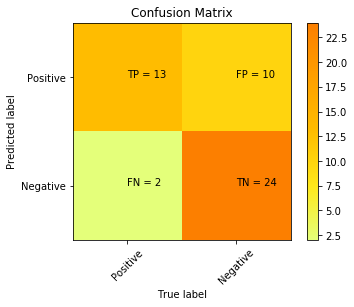

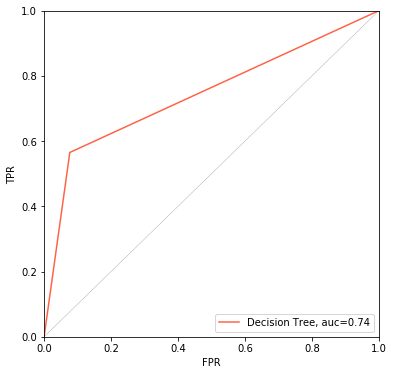

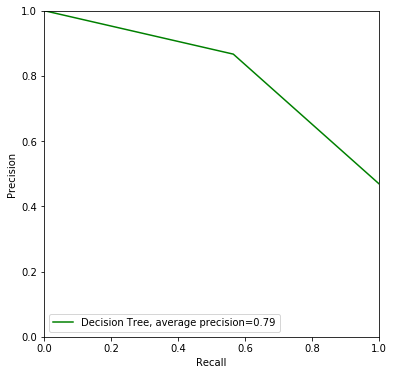

In [56]:
X, y = initialize(df)
X, y = under_sampling(X, y)
X, y = over_sampling2(X, y)
X = standardize(X)
X_train, X_test, y_train, y_test = split(X, y)
h_dt_dict, h_cm_dt, h_figROC_dt, h_figPR_dt = dt(X_train, X_test, y_train, y_test)


In [57]:
print("Cross validaiton before tuning is: ",h_dt_dict["CV"])
print("Cross validaiton after tuning is: ", h_dt_dict["acc"])

Cross validaiton before tuning is:  0.87
Cross validaiton after tuning is:  0.76


### SVM

E:\Users\User\Anaconda3\envs\CEB\lib\site-packages\pandas\core\ops.py:1649: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  result = method(y)


[LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM]

E:\Users\User\Anaconda3\envs\CEB\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
E:\Users\User\Anaconda3\envs\CEB\lib\site-packages\sklearn\model_selection\_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
E:\Users\User\Anaconda3\envs\CEB\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


<Figure size 432x288 with 0 Axes>

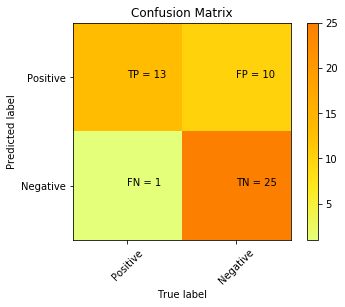

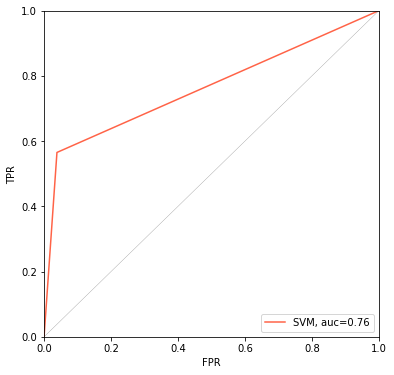

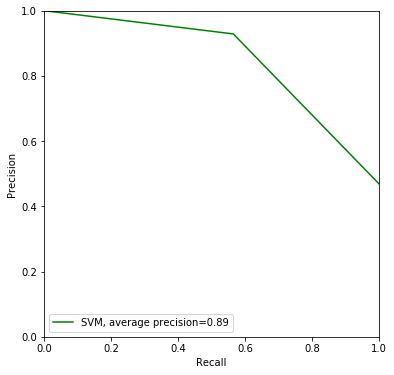

In [58]:
X, y = initialize(df)
X, y = under_sampling(X, y)
X, y = over_sampling2(X, y)
X = standardize(X)
X_train, X_test, y_train, y_test = split(X, y)
h_svm_dict, h_cm_svm, h_figROC_svm, h_figPR_svm = svm(X_train, X_test, y_train, y_test)


In [59]:
print("Cross validaiton before tuning is: ",h_svm_dict["CV"])
print("Cross validaiton after tuning is: ", h_svm_dict["acc"])

Cross validaiton before tuning is:  0.85
Cross validaiton after tuning is:  0.78


#### Comparing Models Using ROC and PR Curve in each experiment

### A)

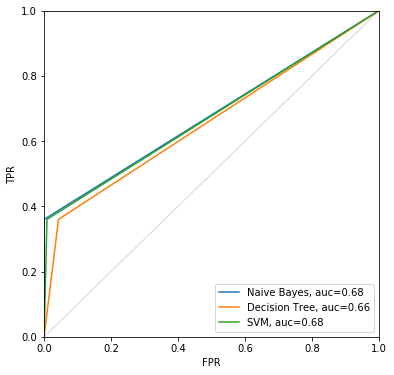

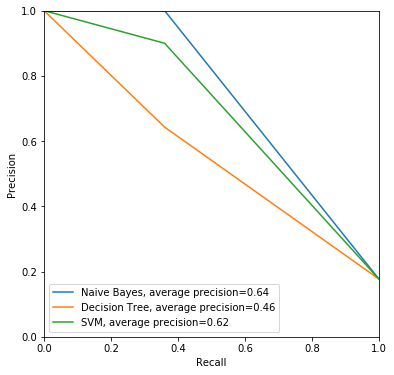

In [60]:
a_ROC, a_PR = full_ROC_PR(a_nb_dict, a_dt_dict, a_svm_dict)

### B)

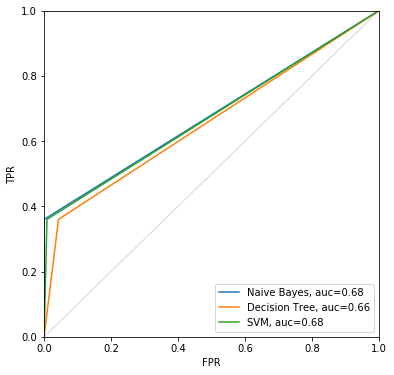

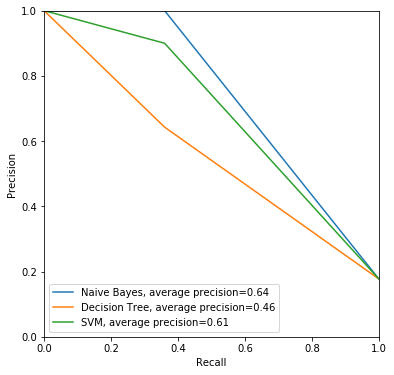

In [61]:
b_ROC, b_PR = full_ROC_PR(b_nb_dict, b_dt_dict, b_svm_dict)

### C)

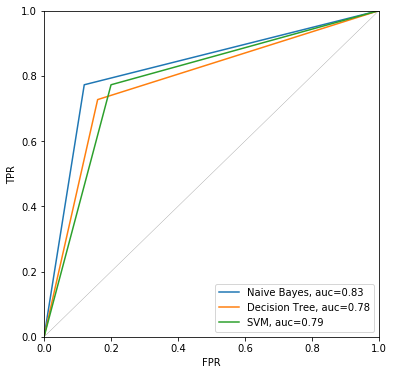

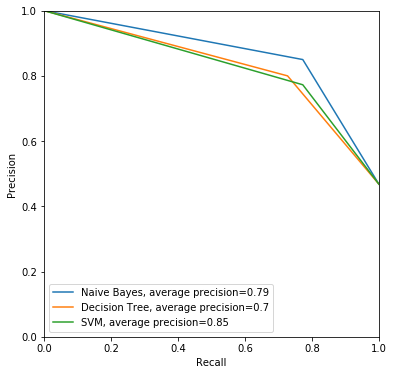

In [62]:
c_ROC, c_PR = full_ROC_PR(c_nb_dict, c_dt_dict, c_svm_dict)

### D)

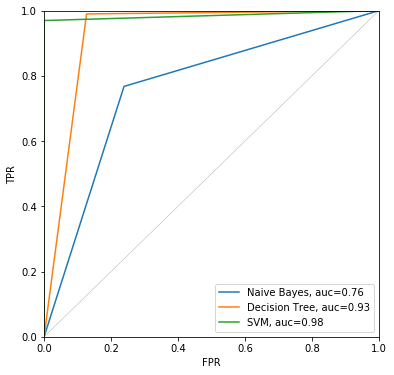

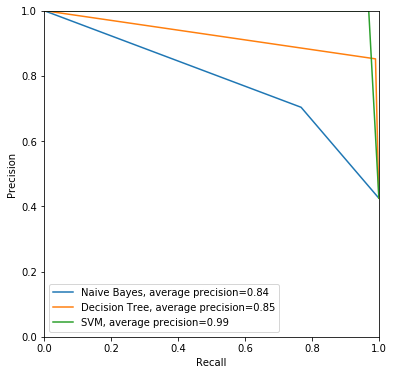

In [63]:
d_ROC, d_PR = full_ROC_PR(d_nb_dict, d_dt_dict, d_svm_dict)

### E)

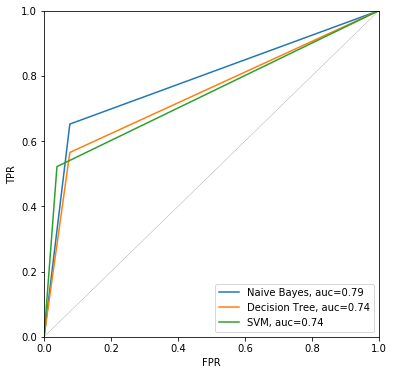

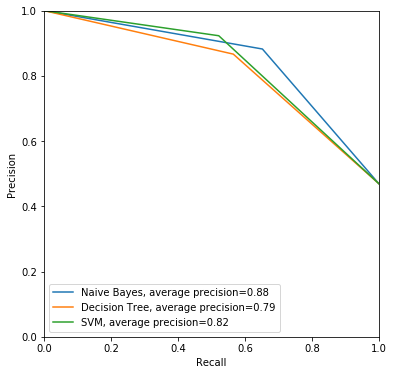

In [64]:
e_ROC, e_PR = full_ROC_PR(e_nb_dict, e_dt_dict, e_svm_dict)

### F)

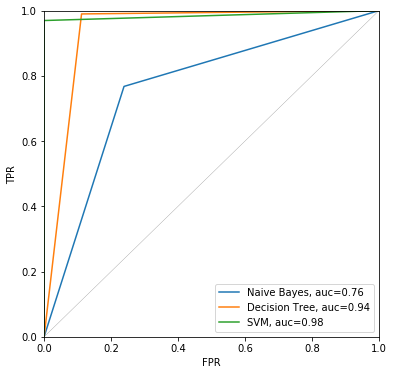

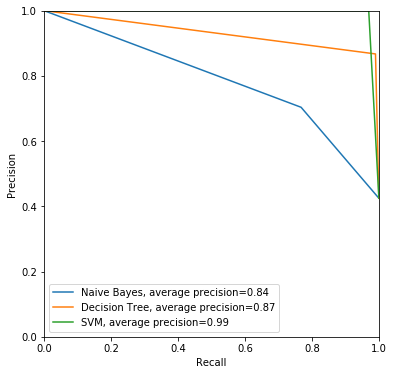

In [65]:
g_ROC, g_PR = full_ROC_PR(g_nb_dict, g_dt_dict, g_svm_dict)

### G)

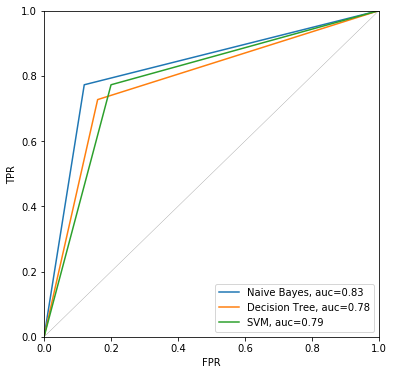

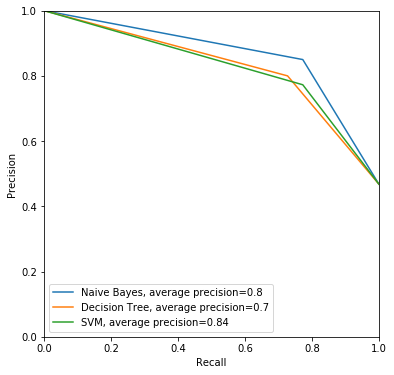

In [66]:
f_ROC, f_PR = full_ROC_PR(f_nb_dict, f_dt_dict, f_svm_dict)

### H)

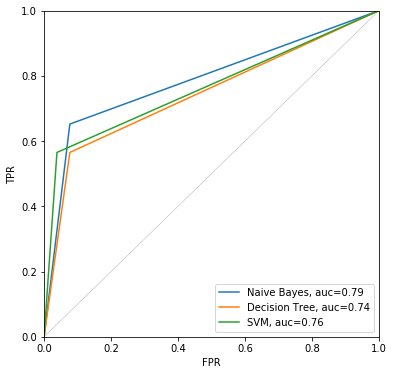

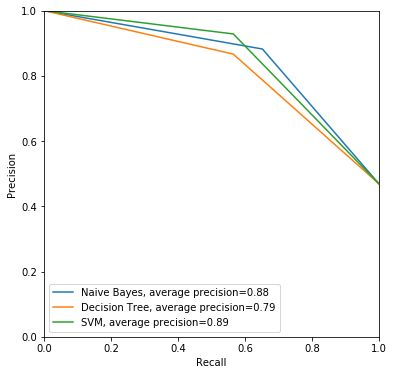

In [67]:
h_ROC, h_PR = full_ROC_PR(h_nb_dict, h_dt_dict, h_svm_dict)

## Model comparison in each experiment

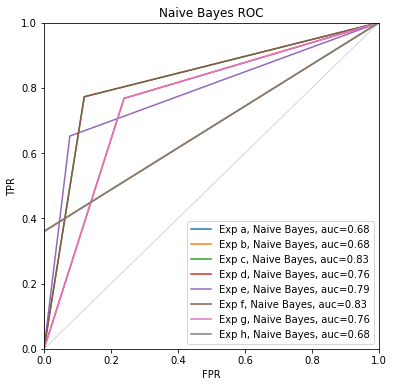

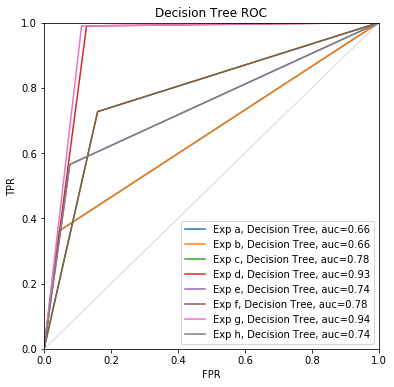

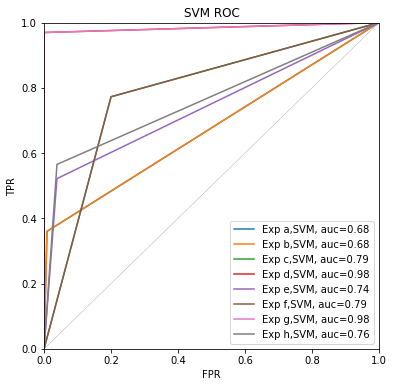

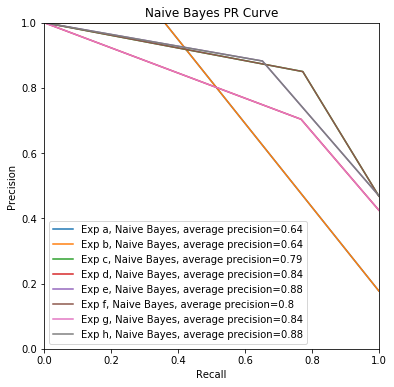

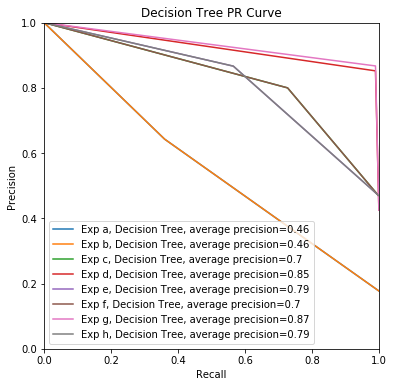

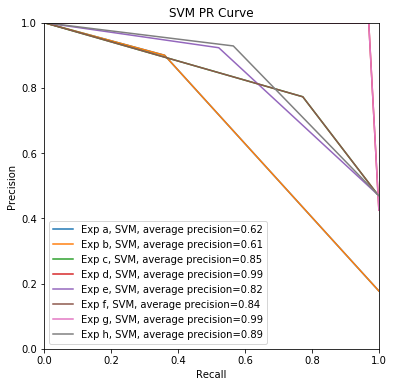

In [68]:
figROC_nb, figROC_dt, figROC_svm, figPR_nb, figPR_dt, figPR_svm = full_ROC_PR2()

## Which model is the best to solve our domain problem among all experiments? Why?

In [69]:
import statistics 

nb_ROC_mean = [a_nb_dict["ROC"], b_nb_dict["ROC"], c_nb_dict["ROC"], d_nb_dict["ROC"], e_nb_dict["ROC"], f_nb_dict["ROC"], g_nb_dict["ROC"], h_nb_dict["ROC"]]
dt_ROC_mean = [a_dt_dict["ROC"], b_dt_dict["ROC"], c_dt_dict["ROC"], d_dt_dict["ROC"], e_dt_dict["ROC"], f_dt_dict["ROC"], g_dt_dict["ROC"], h_dt_dict["ROC"]]
svm_ROC_mean = [a_svm_dict["ROC"], b_svm_dict["ROC"], c_svm_dict["ROC"], d_svm_dict["ROC"], e_svm_dict["ROC"], f_svm_dict["ROC"], g_svm_dict["ROC"], h_svm_dict["ROC"]]

nb_AP_mean = [a_nb_dict["AP"], b_nb_dict["AP"], c_nb_dict["AP"], d_nb_dict["AP"], e_nb_dict["AP"], f_nb_dict["AP"], g_nb_dict["AP"], h_nb_dict["AP"]]
dt_AP_mean = [a_dt_dict["AP"], b_dt_dict["AP"], c_dt_dict["AP"], d_dt_dict["AP"], e_dt_dict["AP"], f_dt_dict["AP"], g_dt_dict["AP"], h_dt_dict["AP"]]
svm_AP_mean = [a_svm_dict["AP"], b_svm_dict["AP"], c_svm_dict["AP"], d_svm_dict["AP"], e_svm_dict["AP"], f_svm_dict["AP"], g_svm_dict["AP"], h_svm_dict["AP"]]

print("ROC mean of Naive Bayes is: ", statistics.mean(nb_ROC_mean))
print("ROC mean of Decision Tree is: ", statistics.mean(dt_ROC_mean))
print("ROC mean of SVM is: ", statistics.mean(svm_ROC_mean))

print("AP mean of Naive Bayes is: ", statistics.mean(nb_AP_mean))
print("AP mean of Decision Tree is: ", statistics.mean(dt_AP_mean))
print("AP mean of SVM is: ", statistics.mean(svm_AP_mean))


ROC mean of Naive Bayes is:  0.765
ROC mean of Decision Tree is:  0.77875
ROC mean of SVM is:  0.8
AP mean of Naive Bayes is:  0.7887500000000001
AP mean of Decision Tree is:  0.7025
AP mean of SVM is:  0.8262499999999999


In [70]:
d_svm_dict["con_mat"]

array([[ 96,   3],
       [  0, 134]], dtype=int64)

In [72]:
g_svm_dict["con_mat"]

array([[ 96,   3],
       [  0, 134]], dtype=int64)

In [73]:
d_nb_dict["con_mat"]

array([[ 76,  23],
       [ 32, 102]], dtype=int64)

In [74]:
g_nb_dict["con_mat"]

array([[ 76,  23],
       [ 32, 102]], dtype=int64)

In [75]:
d_dt_dict["con_mat"]

array([[ 98,   1],
       [ 17, 117]], dtype=int64)

In [76]:
g_dt_dict["con_mat"]

array([[ 98,   1],
       [ 15, 119]], dtype=int64)

#### According to the average precision score and ROC score the model might suite for solving the problem is SVM. One of the reason that SVM might has the most potential to solve this problem because this dataset is not that big. Decision tree is not chosen because decision tree prone to overfit if not pre-prune. Even it is pre-prune, it is difficult to judge how much the debt of the tree can it goes and maximun number of leaf can it produce. Also, this dataset is not big which it could lead to overfitting if decision tree is use. However, this doesn't mean that SVM is prone to big dataset but it will take longer time to process as it need to compute margins of the hyperplan for every features to classify the  groups. Morever, this dataset might have some interaction between features, for example: age and BMI. This gives SVM an edge because it capture the interaction of these features, whereas Naive Bayes treated them as independent. 
#### Here, the SVM is tuned between linear and RBF kernel as there are only 5 features in this dataset. The tuned model used RBF kernel which is mostly used when there is no prior knowledge about data. When using RBF kernel, C and gamma hyperparameters needed to be tuned by using both random search and grid search. Gamma parameter helps to control the width of the RBF kernel and C parameter control the penalty of misclassification. The larger the gamma the longer the width of the kernel. The higher the C parameter, the model higher penalty of misclassify, which means the model cannot misclassify.

## Which experiment is the best for our domain problem for each model? Why?

#### The best experiment for Naive Bayes and Decision Tree model is either experiment D or G. This is because both use oversampling method that result in high ROC and AP score. Even though experiment H give the highest precision score, the method of doing the experiment involve down sampling then oversampling which is not appropraite. This due to the total number of observations is 425, 71 observations is labelled as DM and other 354 is labelled as non-DM. The interested outcome (DM) is accounted for only 16% of the total dataset therefore down sampling could make bias prediction. If i were to one of the experiment from D or G, I would choose G as it involve standardization which helps in the model prediction.

#### The best experiment for SVM is D because it gives very high precision and accuracy score. SVM shows very good model performance even though the data is not  standardized only over sampling is done. According to the data visualization, the data is quite complex. SVM allows many type of kernels that could help in classification (DM, non-DM) for different type of data. SVM could be used to help in classifying using tuned hyperparameter with appropriate soft margin to find the best hyperplane.